# Exoplanets A: Lab Assignment
*Author: Lukas Welzel*

## Purpose
Collect all plots for the assignment.

## WIP - improvements
Notable TODOs:
-


# Setup

## Library import

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from scipy.interpolate import griddata

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 10

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from mpl_toolkits.axes_grid1 import make_axes_locatable
RGbinary = mpl.colors.ListedColormap(['red', 'green'])

import seaborn as sns
import mpld3
from ipywidgets import *

%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 300

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# other
from tqdm import tqdm
from copy import deepcopy
from itertools import product

## Local library import

In [2]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries

# Import local libraries
from read_all_planets import read_experiments_hdf5

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.


# Data import
We retrieve all the required data for the analysis.

In [3]:
# data is hierarchical dict with all experiment data in the structure:
#   failed_configs:             df with config information for those that failed to run properly
#   run-m_core-VALUE-f-VALUE:   dict with single experiment data    - e.g. run-m_core-3_0-f-0_1
#       header                  dict with header data               - 'burn_min1', 'burn_min2', 'f', 'initial_mass',
#                                                                     'initial_z', 'm_core', 'name', 'path', 'success', 'version_number'
#       history                 df with history data                - 'log_star_age', 'luminosity', 'radius', 'star_mass',
#                                                                     'surface_cell_temperature', 'conv_mx1_top_r', 'conv_mx1_top',
#                                                                     'center_entropy', 'max_entropy', 'log_L', 'log_Teff', 'log_center_T',
#                                                                     'log_center_Rho', 'log_R'
#       global_properties       df with global data at step         - 'step', 'model_number', 'num_zones', 'star_age', 'Teff',
#                                                                     'photosphere_L', 'photosphere_r', 'star_mass', 'power_nuc_burn'
#       zone_properties         df with zone data at step           - 'zone', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H',
#                                                                     'y_mass_fraction_He', 'z_mass_fraction_metals', 'mu', 'grada',
#                                                                     'opacity', 'gradT', 'gradr', 'sch_stable', 'ledoux_stable'
#   run-m_core-VALUE-f-VALUE...
#
# the zone_properties df has a hierarchical index "step" which corresponds to the "step" column in the global_properties df
#
# UNITS
#
#    radius ! radius at outer boundary of zone (in Rsun units)
#    luminosity ! luminosity at outer boundary of zone (in Lsun units)
#    logL ! log10(max(1d-2,L/Lsun))
#    star_mass ! in Msun units
#    zone       ! numbers start with 1 at the surface
#    mass       ! m/Msun. mass coordinate of outer boundary of cell.
#    logR       ! log10(radius/Rsun) at outer boundary of zone
#    logT       ! log10(temperature) at center of zone
#    logRho     ! log10(density) at center of zone
#    logP       ! log10(pressure) at center of zone
#    mu ! mean molecular weight per gas particle (ions + free electrons)


DATA_FILE = "exoplanet_A_MESA_lab_GS_RS_LONG.hdf5"

data = read_experiments_hdf5(loc=DATA_FILE)

failed_experiments = deepcopy(data["failed_configs"])
del data["failed_configs"]

In [4]:
# select data subset
# print(data)

m_p_core_list = [3., 5., 7., 10., 12.]
f_list = [0.1, 0.01]

inlist_values = list(product(m_p_core_list, f_list))

def reduce_to_ass_hist(cols):
    return [[data[entry]["header"]["m_core"],
             data[entry]["header"]["f"],
             data[entry]["history"][cols]]
            for entry in entries
            if (data[entry]["header"]["m_core"], data[entry]["header"]["f"]) in inlist_values]


# Data processing
## Preprocessing

In [5]:
entries = [key for key in data.keys()]

def get_data_from_hist(cols):
    return [[data[entry]["header"]["m_core"], data[entry]["header"]["f"], data[entry]["history"][cols]] for entry in entries]

m_cores = np.array([entry[0] for entry in get_data_from_hist([])])
fs = np.array([entry[1] for entry in get_data_from_hist([])])

cross = np.array([m_cores, fs]).T
max_m_core = np.max(m_cores)
max_f = np.max(fs)

def get_data_from_zone(cols):
    return [[data[entry]["header"]["m_core"], data[entry]["header"]["f"], data[entry]["zone_properties"][cols]] for entry in entries]

def get_data_from_global(cols):
    return [[data[entry]["header"]["m_core"], data[entry]["header"]["f"], data[entry]["global_properties"][cols]] for entry in entries]

def get_final_values_from_zones(_planets):
    for i, planet in enumerate(_planets):
        _planets[i][-1] = planet[-1].xs(planet[-1].index.get_level_values(0)[-1])
    return _planets

In [6]:
def densify_planets(_planets):
    """
    Produce a dense DataFrame from a list of [[m_core, f, DataFrame], ...] where each row has the m_core, f as columns fo the DataFrame
    :param _planets:
    :return:
    """
    for i, planet in enumerate(_planets):
        _planets[i][2].insert(0, "m_core", planet[0])
        _planets[i][2].insert(1, "f", planet[1])
        _planets[i] = _planets[i][2]
    return pd.concat(_planets, axis=0)

def interp_planet_hist(xi, _planets, point_cols=["m_core", "f", "log_star_age"], value_cols=["radius"]):
    return griddata(points=_planets[point_cols].to_numpy(),
                    values=_planets[value_cols].to_numpy(),
                    xi=xi,
                    method="linear", rescale=True)


In [7]:
def color_m_core(_m_core):
    return mpl.colormaps['viridis'](_m_core / max_m_core)

def color_f(_f):
    return mpl.colormaps['viridis'](np.log10(max_f) / np.log10(_f))

def size_m_core(_m_core):
    return 20. * (_m_core / max_f) + 1.

def lw_m_core(_m_core):
    return 2. * (_m_core / max_f)

def lw_f(_f):
    return 2 * np.log10(max_f) / np.log10(_f)

### Failed Runs

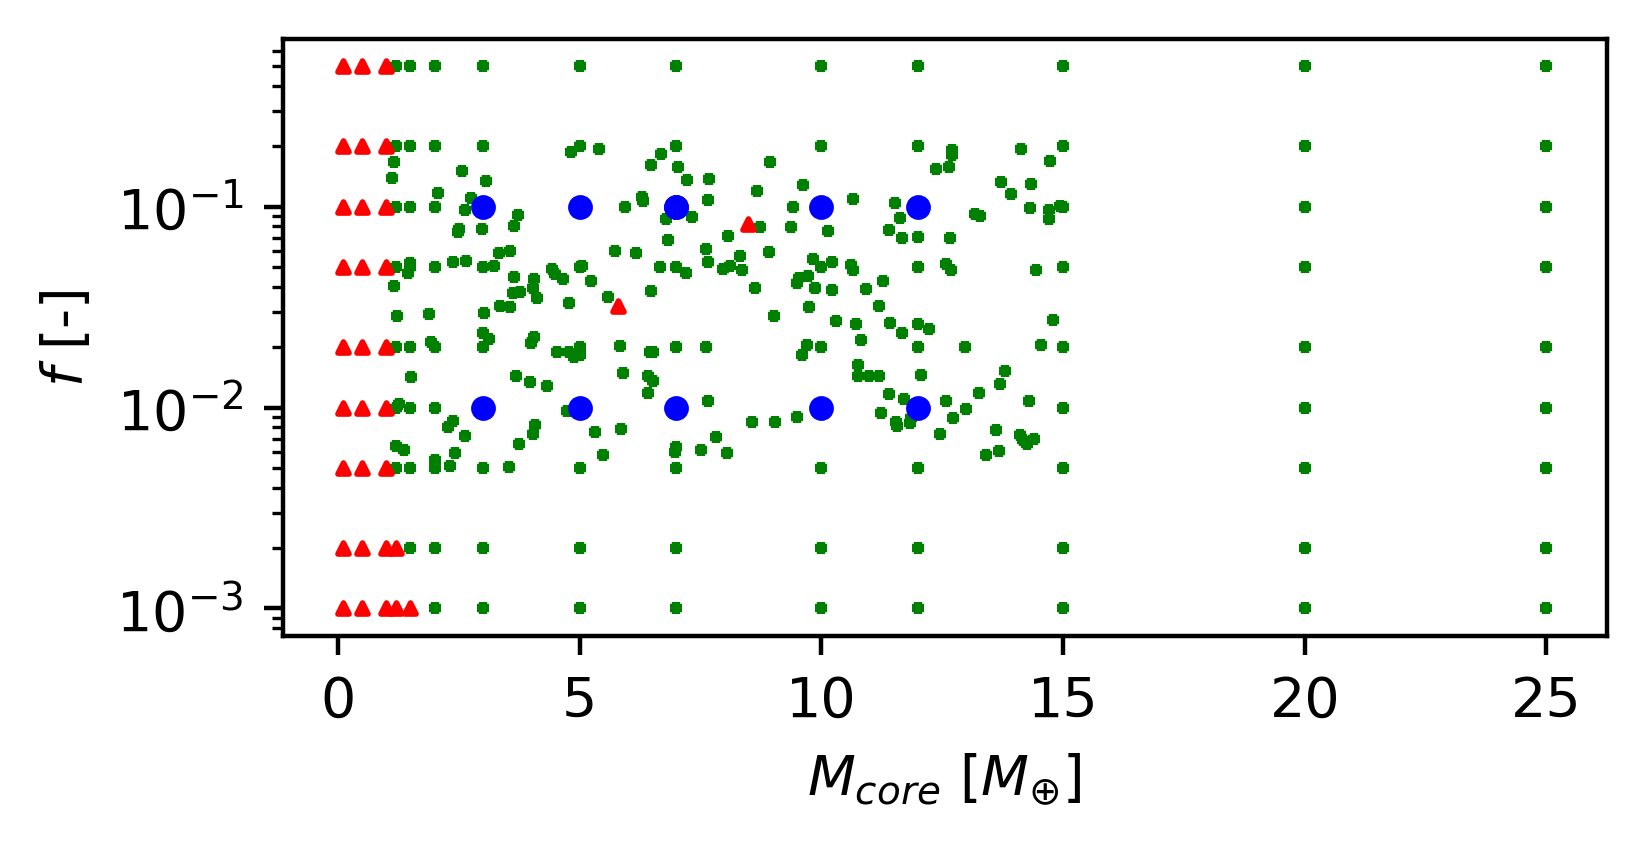

In [8]:
%matplotlib inline
unique_m_cores = np.unique(np.append(m_cores, failed_experiments["m_core"].to_numpy()))
unique_fs = np.unique(np.append(fs, failed_experiments["f"].to_numpy()))

planets = get_data_from_hist(["log_star_age"])
ass_planets = reduce_to_ass_hist(["log_star_age"])


fig, ax = plt.subplots(constrained_layout=True, figsize=(4,2))

def generate_rad_time_go_trace(planet, c="green", marker="+", **kwargs):
    m_core = planet[0]
    f = planet[1]
    trace = ax.scatter(m_core, f, c=c, marker=marker, **kwargs)
    return trace

for planet in planets:
    __ = generate_rad_time_go_trace(planet, s=4)
__ = generate_rad_time_go_trace(planet, s=4, label="Successful")

for planet in ass_planets:
    __ = generate_rad_time_go_trace(planet, c="blue", marker="o", s=12)
__ = generate_rad_time_go_trace(planet, c="blue", marker="o", s=12, label="Required")

ax.scatter(failed_experiments["m_core"], failed_experiments["f"], color="red", s=4, marker="^", label="Failed")

# ax.grid(which='minor', color='gray', linestyle='solid', linewidth=0.75)
# ax.tick_params(which='minor', bottom=False, left=False)
# ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_title("Successful, failed and required experiments.", fontsize=8)
ax.set_xlabel(r"$M_{core}$ [$M_{\oplus}$]")
ax.set_ylabel(r"$f$ [-]")

plt.savefig("run_overview.png", dpi=350)

plt.show()

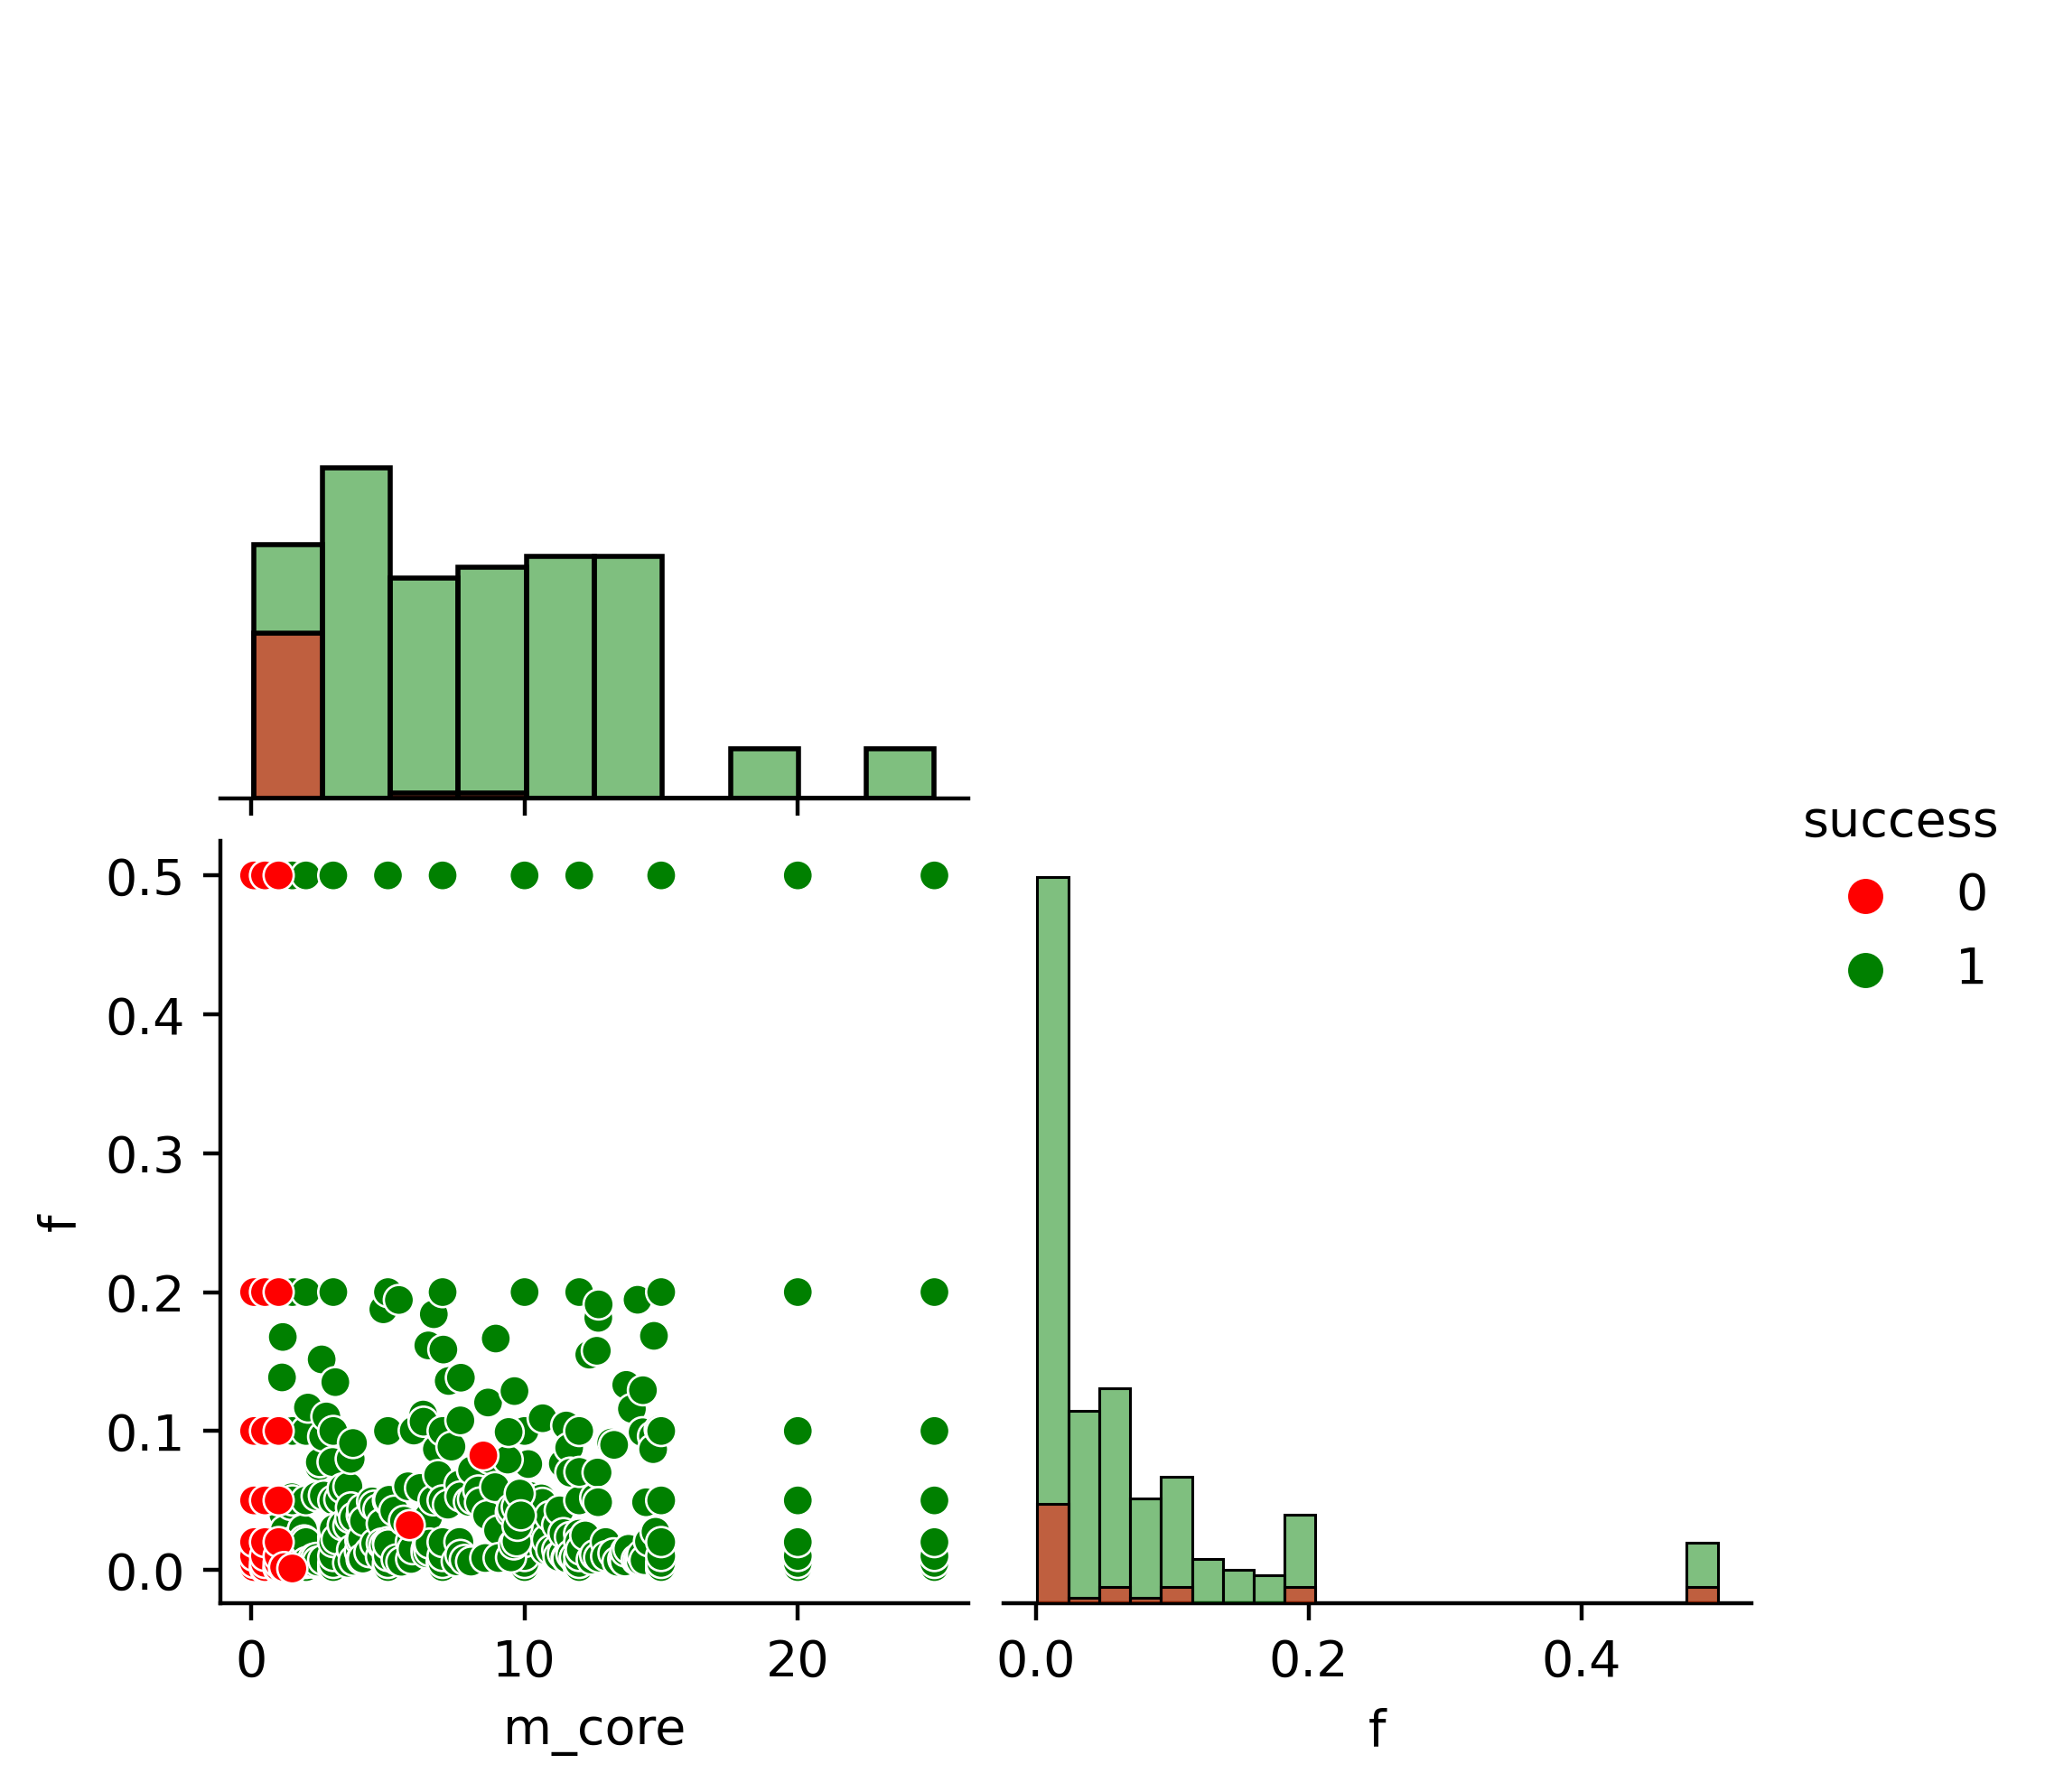

In [9]:
# corner plot failed runs

planets = get_data_from_hist(["log_star_age"])

def generate_rad_time_go_trace(planet):
    m_core = planet[0]
    f = planet[1]
    return [m_core, f, 1]

success = [generate_rad_time_go_trace(planet) for planet in planets]
success = pd.DataFrame(success, columns=["m_core", "f", "success"])
cols = ["m_core", "f", "success"]
failures = failed_experiments[cols]

run_data = pd.concat([success, failures], axis=0)

sns.pairplot(run_data, kind="scatter", hue="success", palette={0: "red", 1:"green"}, diag_kind="hist", corner=True)
plt.show()

## Plotting

### Radius vs time
The evolution of the radius of the planets with time.

In [10]:
%matplotlib inline
planets = get_data_from_hist(["radius", "log_star_age"])

def generate_rad_time_go_trace(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["radius"].to_numpy()
    log_star_age = planet[2]["log_star_age"].to_numpy()
    trace = go.Scatter3d(x=radius,
                         y=log_star_age,
                         z=np.ones_like(radius) * m_core,
                         mode='markers', marker={"size":np.log10(radius * 109) * 10,
                                                 "color":np.tile(color_f(f), (len(radius), 1)),
                                                 # "colorscale": 'Viridis',
                                                 "opacity":0.8
                                                 }
                         )
    return trace

traces = [generate_rad_time_go_trace(planet) for planet in planets]

fig = go.Figure(data=traces,)

fig.update_layout(
    scene = dict(
        xaxis_title='Planet Radius []',
        yaxis_title='Star Age [log]',
        zaxis_title='f [-]',
    zaxis=dict(type='log')
    ),
)

# ply.iplot(fig, filename='radius_age')
fig.write_html("radius_age_f_m_core.html")

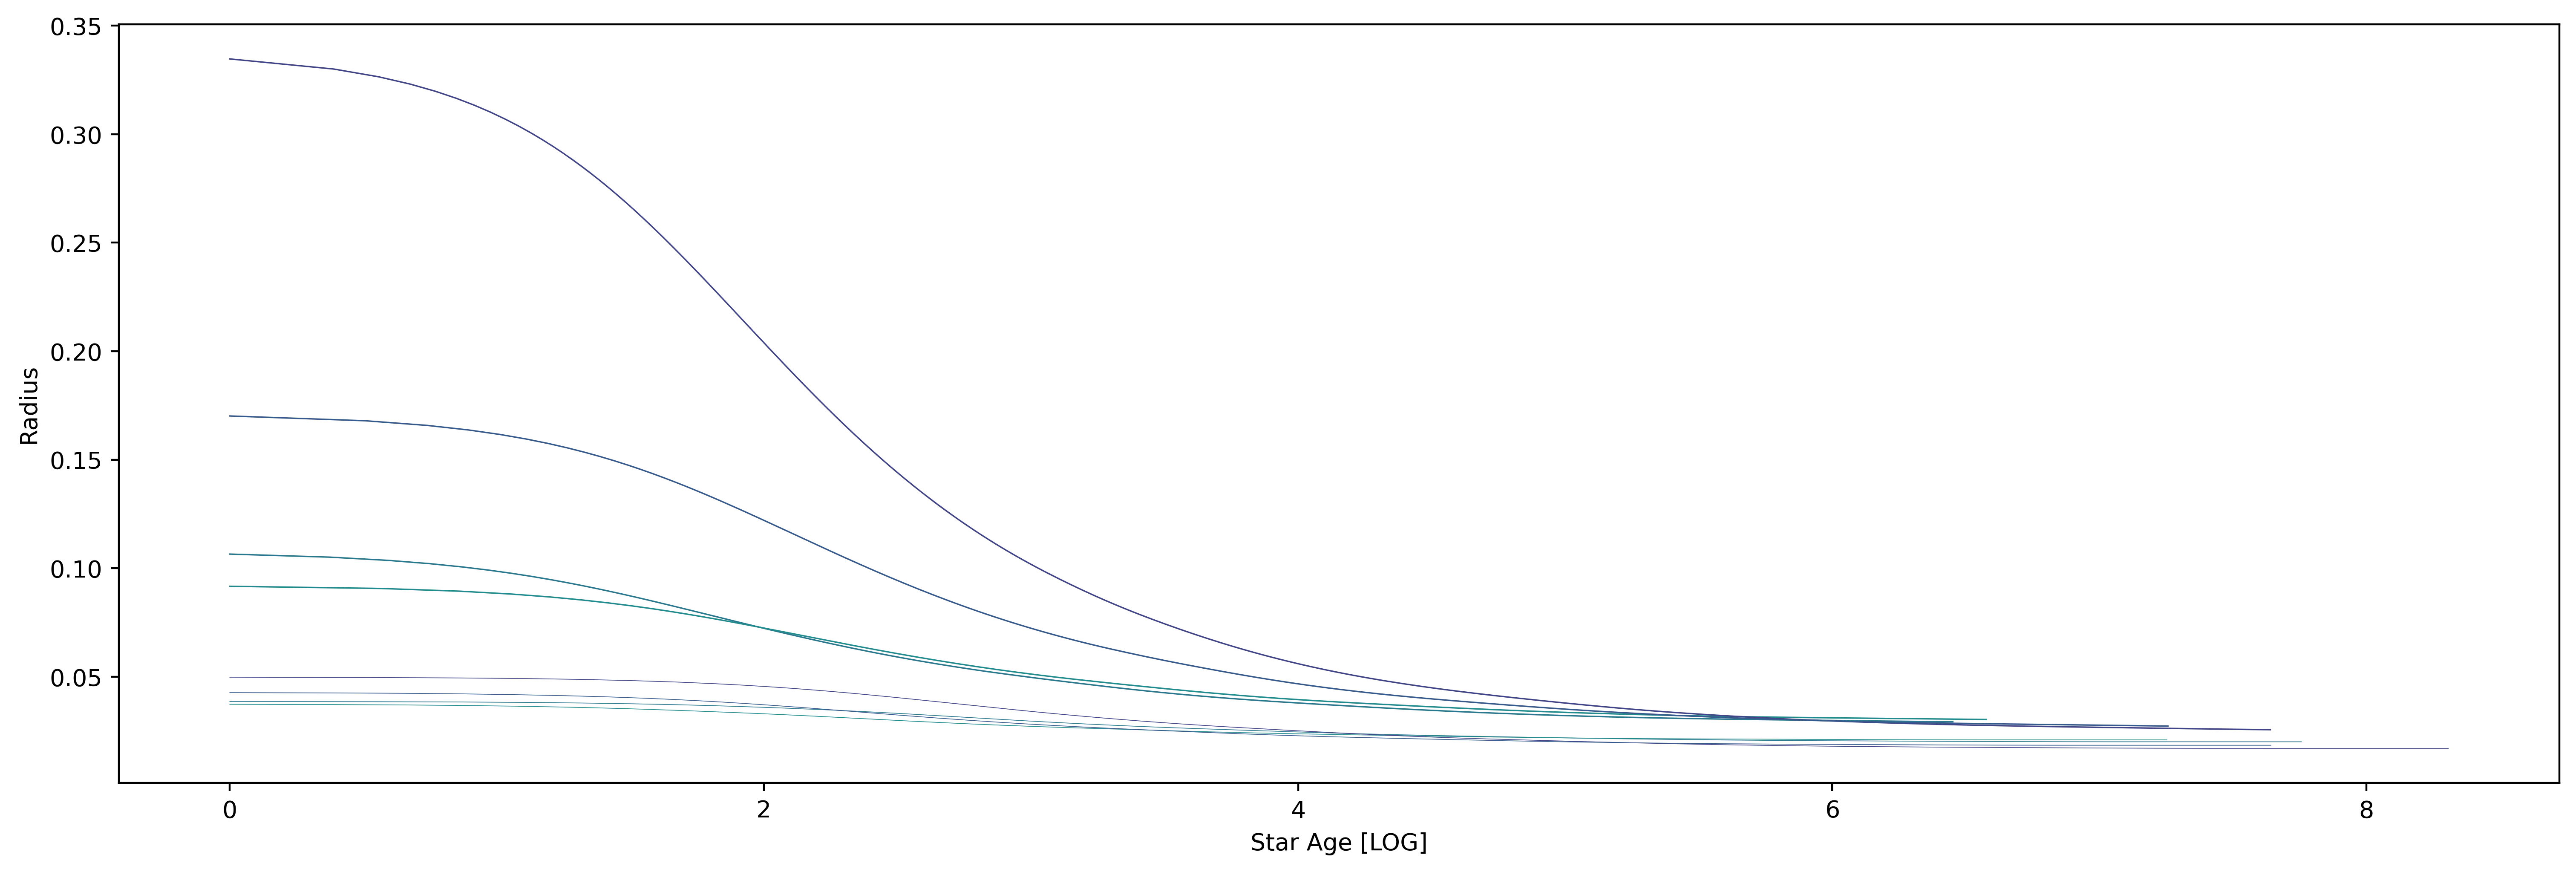

In [11]:
# planets = get_data_from_hist(["radius", "log_star_age"])
planets = reduce_to_ass_hist(["radius", "log_star_age"])

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_rad_time_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    if m_core < 5:
        return
    radius = planet[2]["radius"].to_numpy() # [:-10]
    # radius = (radius - np.min(radius)) / np.max(radius - np.min(radius))
    # radius = radius / np.max(radius)
    # radius = radius / np.max(radius)
    log_star_age = planet[2]["log_star_age"].to_numpy()
    log_star_age = (log_star_age - np.min(log_star_age)) # / np.max(log_star_age - np.min(log_star_age))
    # log_star_age = log_star_age / np.max(log_star_age)

    ax0.plot(log_star_age, radius, linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #
    return

[generate_rad_time_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Star Age [LOG]")
ax0.set_ylabel("Radius")
# ax0.set_ylim(-1, 1.)
# ax0.set_xscale("log")

plt.savefig("radius_star_age.png", dpi=350)
plt.show()

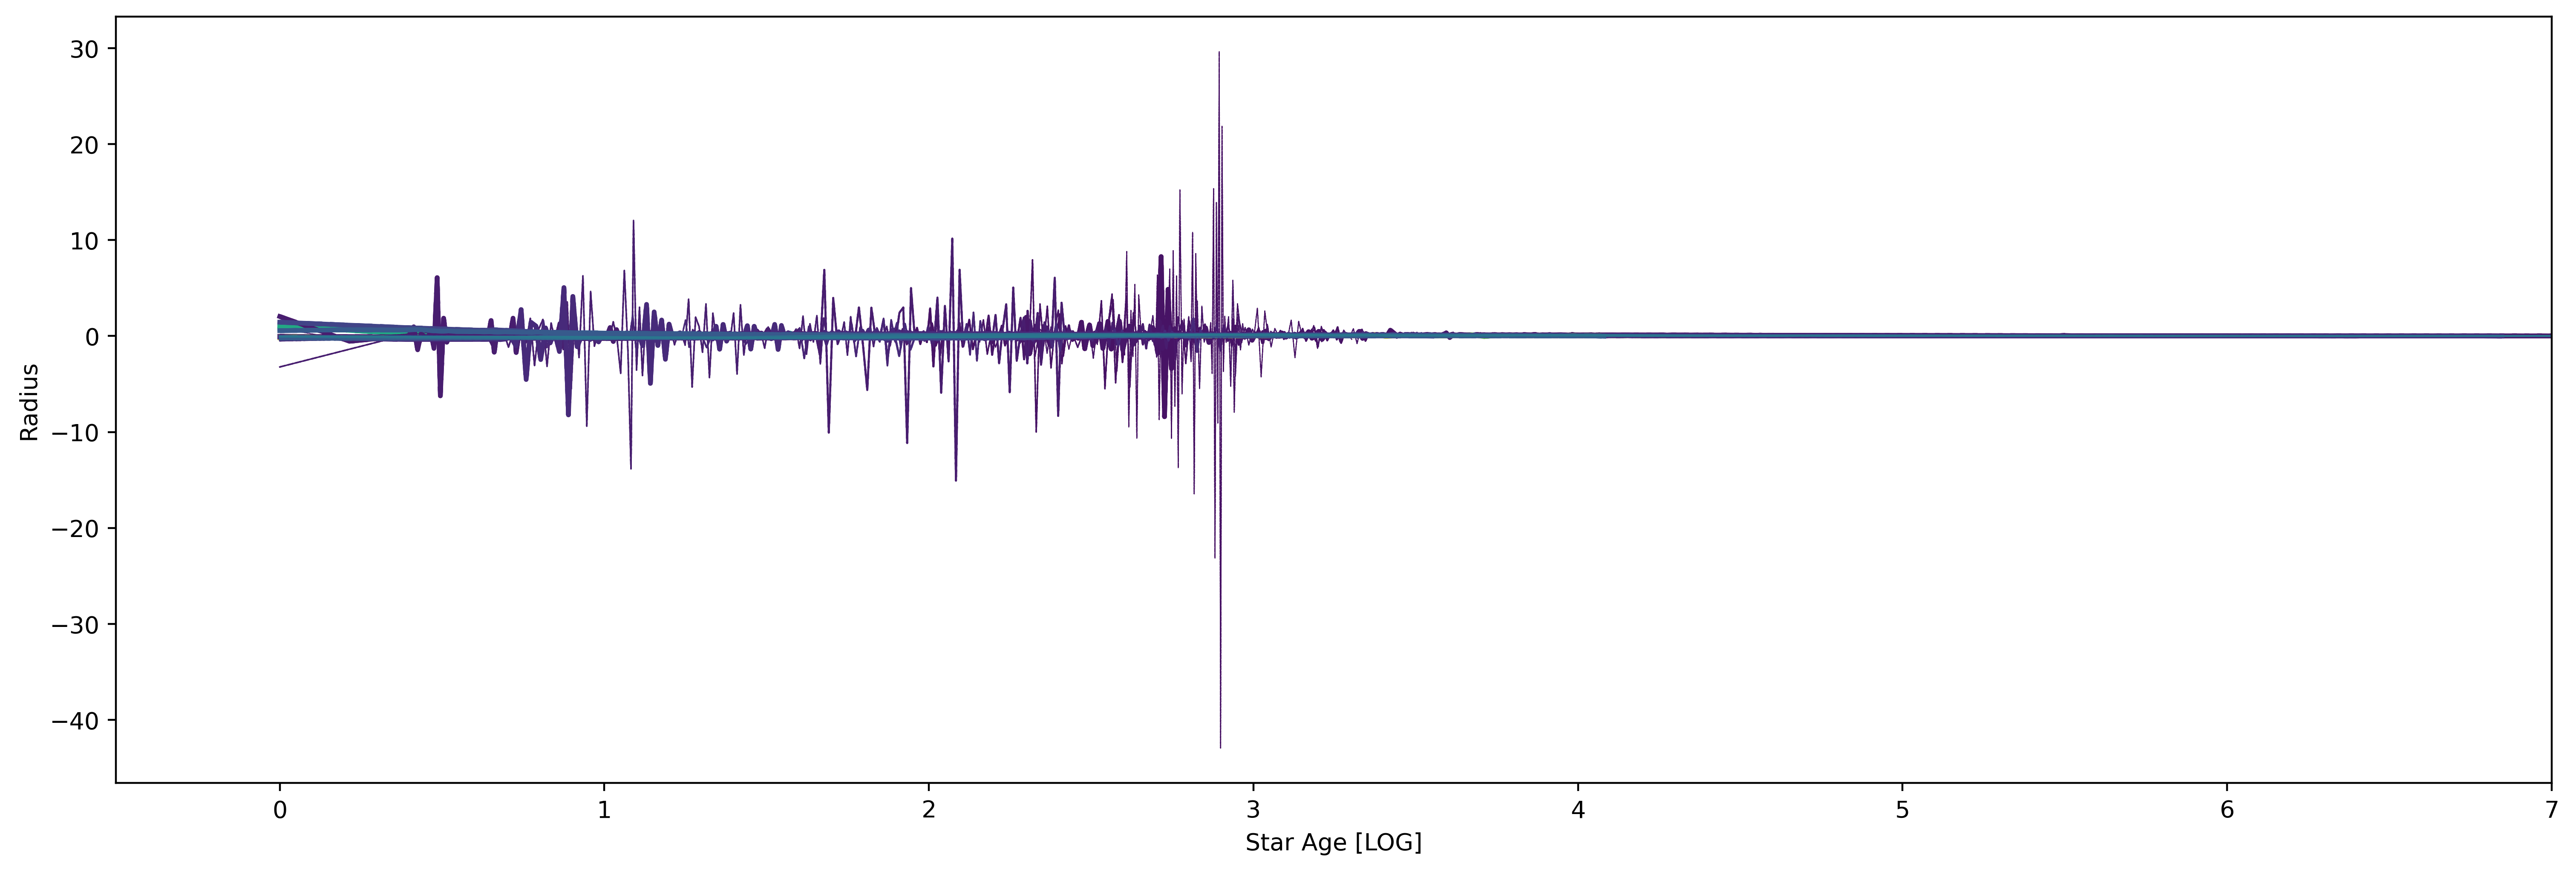

In [83]:
from scipy.interpolate import UnivariateSpline

planets = get_data_from_hist(["radius", "log_star_age"])
# planets = reduce_to_ass_hist(["radius", "log_star_age"])

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_rad_time_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    try:
        radius = planet[2]["radius"].to_numpy()
        radius = radius / np.max(radius)
        log_star_age = planet[2]["log_star_age"].to_numpy()
        log_star_age = (log_star_age - np.min(log_star_age))

        spl1 = UnivariateSpline(log_star_age, radius, k=4, s=0)
        spl2 = UnivariateSpline(log_star_age, radius, k=4, s=0)
        spl3 = UnivariateSpline(log_star_age, radius, k=4, s=0)

        n=2
        # r1 = spl1.derivative(n=n)(log_star_age)
        # r2 = spl2.derivative(n=n)(log_star_age)
        # r3 = spl3.derivative(n=n)(log_star_age)

        r1 = spl1.derivative(n=n)(log_star_age)
        r2 = spl2.derivative(n=n)(log_star_age)
        r3 = spl3.derivative(n=n)(log_star_age)


        # ax0.plot(log_star_age, r, linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed") # c=color_f(f)) #
        # ax0.plot(log_star_age, radius, linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #

        # ax0.plot(log_star_age, ((radius - r1)/radius)**2, linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #
        # ax0.plot(log_star_age, ((radius - r2)/radius)**2, linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed") # c=color_f(f)) #
        # ax0.plot(log_star_age, ((radius - r3)/radius)**2, linewidth=lw_f(f), c=color_m_core(m_core), ls="dotted") # c=color_f(f)) #

        ax0.plot(log_star_age, r1, linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #
        ax0.plot(log_star_age, r2, linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed") # c=color_f(f)) #
        ax0.plot(log_star_age, r3, linewidth=lw_f(f), c=color_m_core(m_core), ls="dotted") # c=color_f(f)) #
    except ValueError:
        pass

    return

[generate_rad_time_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Star Age [LOG]")
ax0.set_ylabel("Radius")
# ax0.set_ylim(-1, 1.)
ax0.set_xlim(None, 7)
# ax0.set_xscale("log")

plt.savefig("radius_star_age.png", dpi=350)
plt.show()

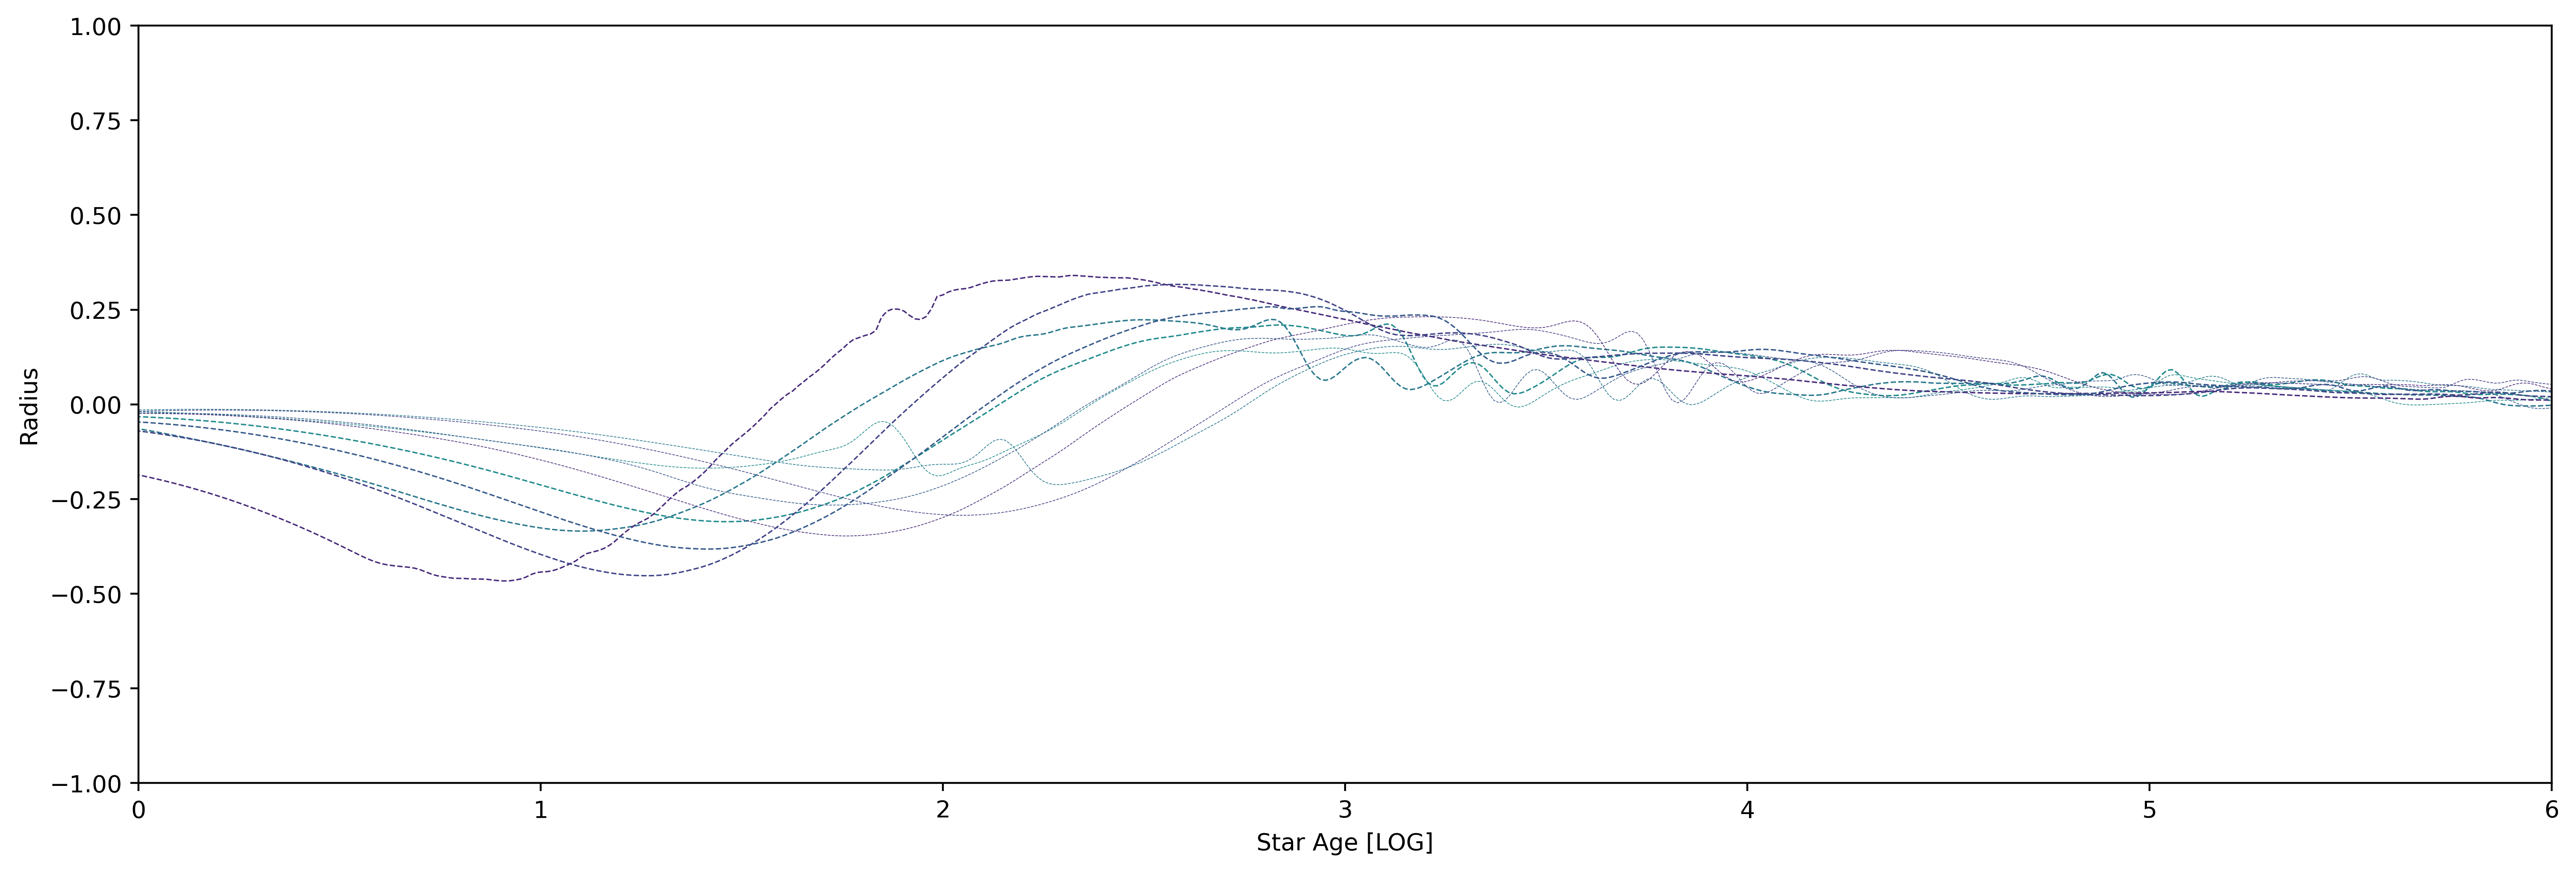

In [104]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

# planets = get_data_from_hist(["radius", "log_star_age"])
planets = reduce_to_ass_hist(["radius", "log_star_age"])

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_rad_time_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]


    radius = planet[2]["radius"].to_numpy()
    radius = radius / np.max(radius)
    log_star_age = planet[2]["log_star_age"].to_numpy()
    log_star_age = (log_star_age - np.min(log_star_age))

    x = np.linspace(log_star_age[0]-1, log_star_age[-1] + 5, 1000)
    spl1 = UnivariateSpline(log_star_age, radius, k=4, s=0)(x)

    n=2

    r1 = savgol_filter(spl1, window_length=11, polyorder=2, deriv=2, delta=(log_star_age[-1]-1 - log_star_age[0]  + 5) / 1000, mode="nearest", cval=1.)


    # ax0.plot(log_star_age, r, linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed") # c=color_f(f)) #
    # ax0.plot(log_star_age, radius, linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #

    # ax0.plot(log_star_age, ((radius - r1)/radius)**2, linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #
    # ax0.plot(log_star_age, ((radius - r2)/radius)**2, linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed") # c=color_f(f)) #
    # ax0.plot(log_star_age, ((radius - r3)/radius)**2, linewidth=lw_f(f), c=color_m_core(m_core), ls="dotted") # c=color_f(f)) #

    # ax0.plot(log_star_age, radius, linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #
    # ax0.plot(x, spl1, linewidth=lw_f(f), c=color_m_core(m_core), ls="dotted") # c=color_f(f)) #
    ax0.plot(x, r1, linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed") # c=color_f(f)) #



    return

[generate_rad_time_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Star Age [LOG]")
ax0.set_ylabel("Radius")
# ax0.set_ylim(-1, 1.)
ax0.set_xlim(0., 6)
# ax0.set_xscale("log")
ax0.set_ylim(-1, 1)

plt.savefig("radius_star_age.png", dpi=350)
plt.show()
plt.close()

C:\Users\lukas\anaconda3\envs\exopa\lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning:

invalid value encountered in divide

C:\Users\lukas\anaconda3\envs\exopa\lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning:

divide by zero encountered in divide

C:\Users\lukas\anaconda3\envs\exopa\lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning:

invalid value encountered in divide

C:\Users\lukas\anaconda3\envs\exopa\lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

divide by zero encountered in divide

C:\Users\lukas\anaconda3\envs\exopa\lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

invalid value encountered in divide

C:\Users\lukas\anaconda3\envs\exopa\lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning:

invalid value encountered in add

C:\Users\lukas\anaconda3\envs\exopa\lib\site-packages\numpy\lib\function_base.py:1264: RuntimeWarning:

divide by zero encountered in scalar divide



LinAlgError: SVD did not converge in Linear Least Squares

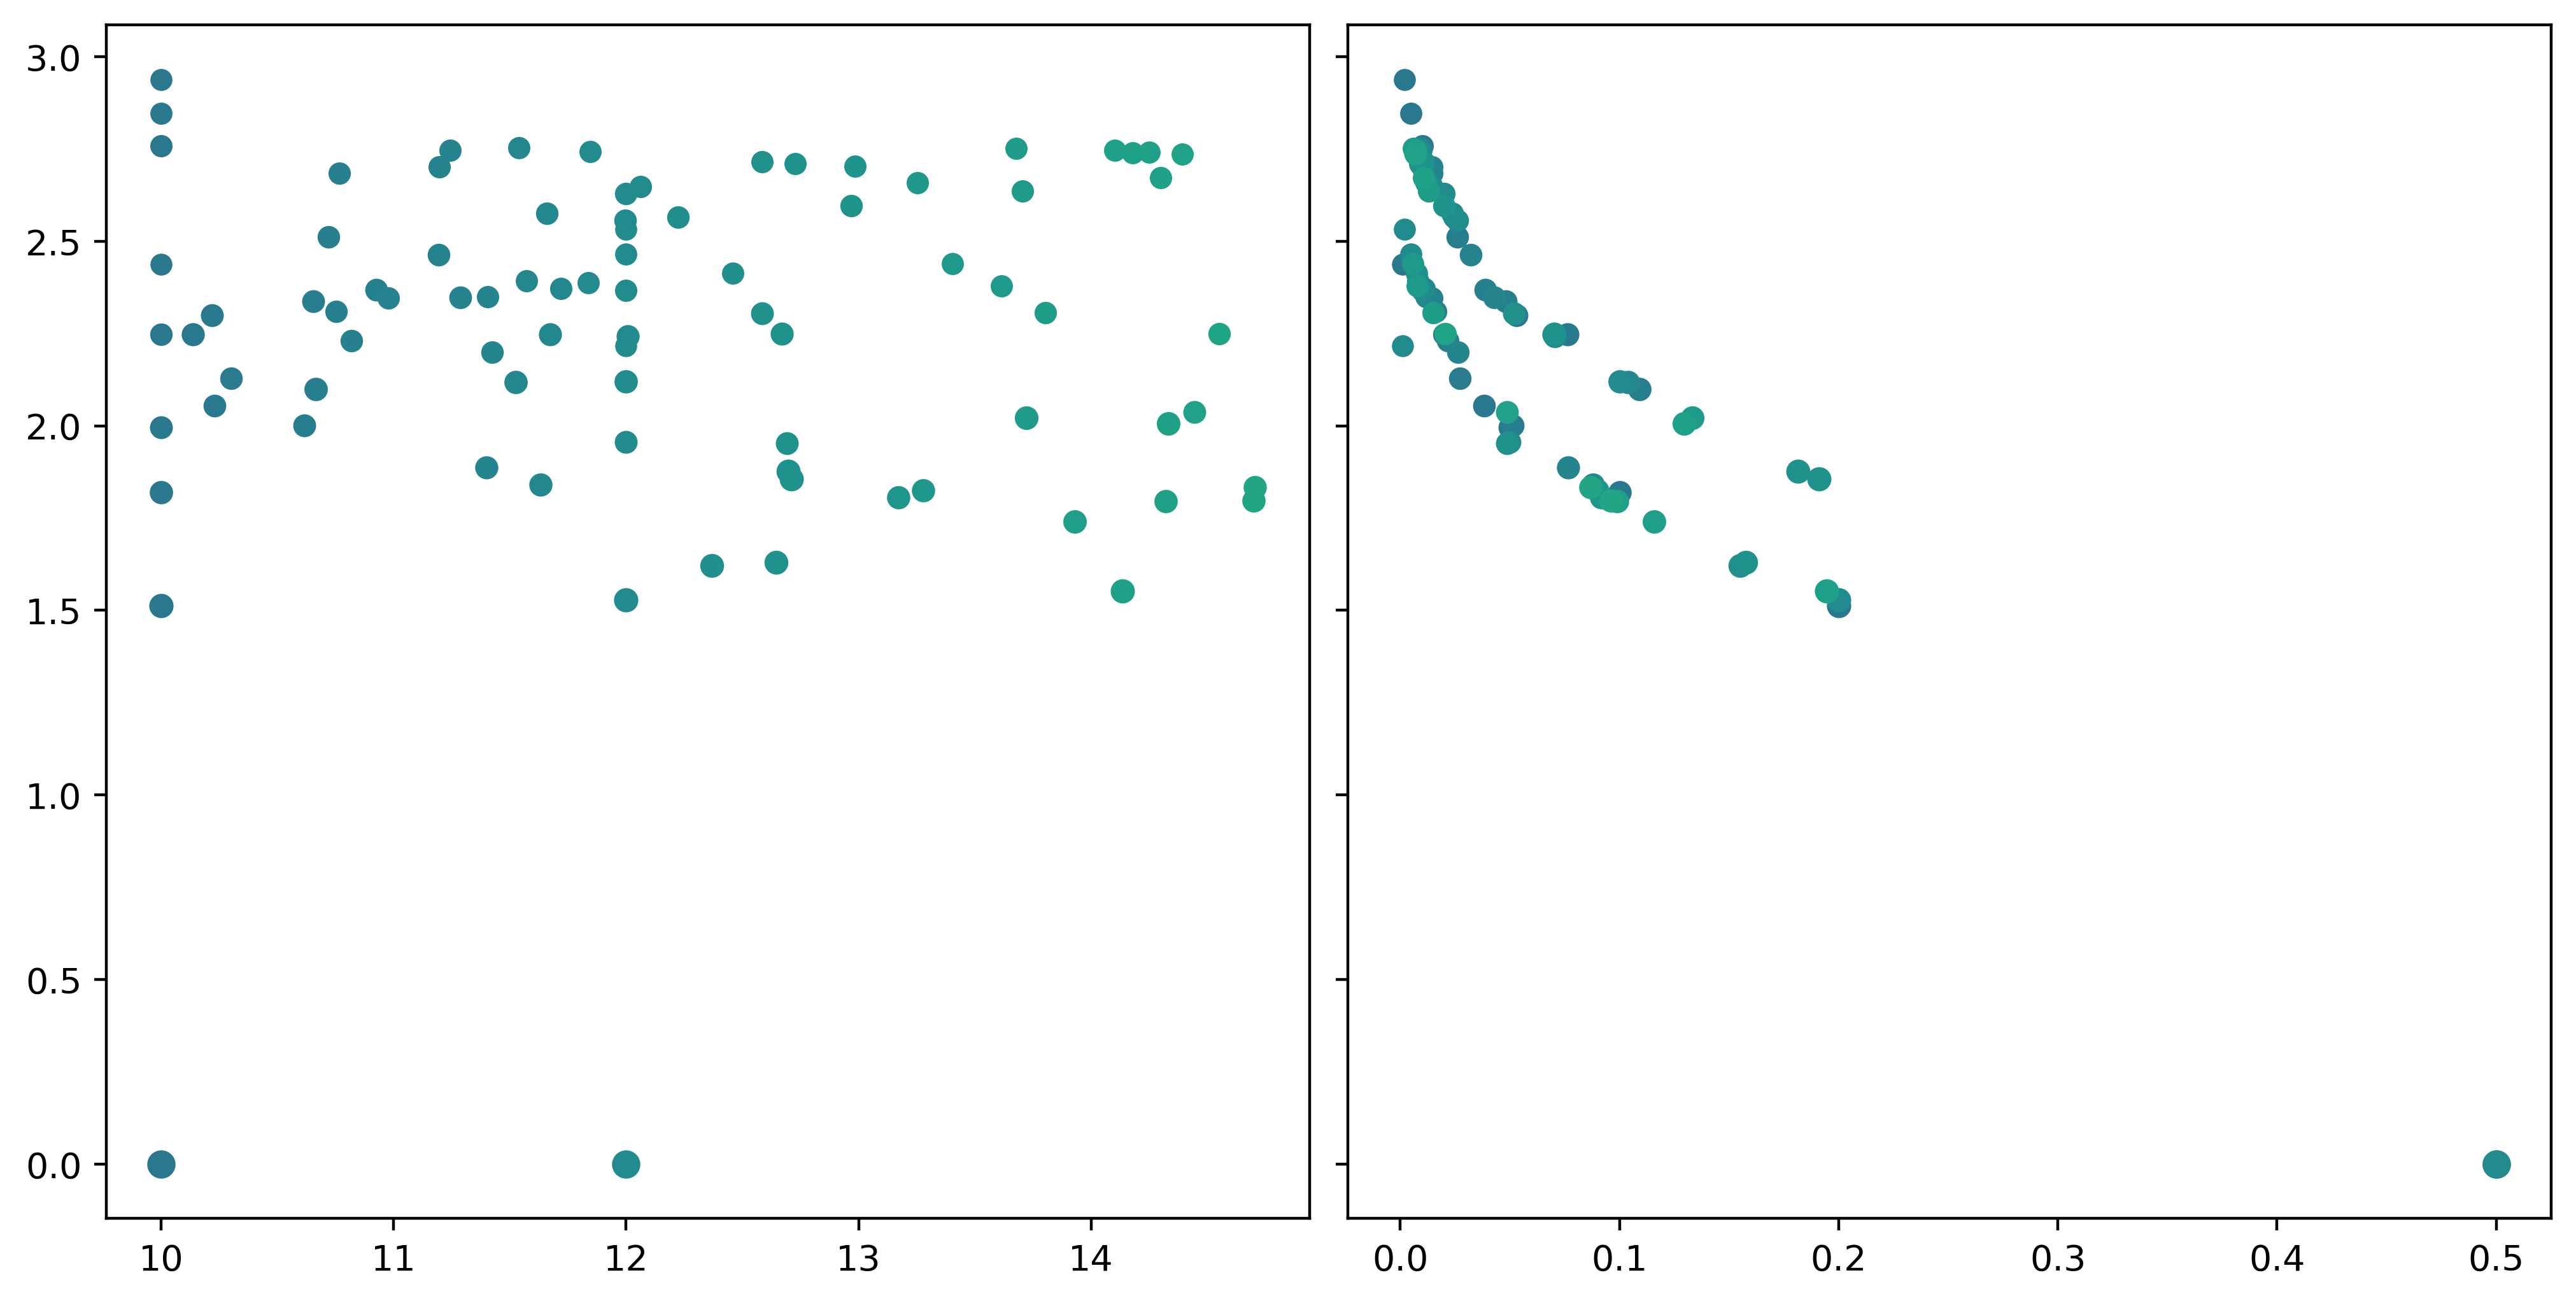

In [12]:
planets = get_data_from_hist(["radius", "log_star_age"])
from scipy.signal import savgol_filter
# planets = reduce_to_ass_hist(["radius", "log_star_age"])

fig, (ax0, ax1) = plt.subplots(1, 2, constrained_layout=True, sharey=True,  figsize=(10, 5))

def generate_inversion_time_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["radius"].to_numpy() # [:-10]
    radius = radius / np.max(radius)
    log_star_age = planet[2]["log_star_age"].to_numpy()
    log_star_age = (log_star_age - np.min(log_star_age))

    drdt = savgol_filter(np.gradient(radius, log_star_age), window_length=3, polyorder=1)

    inversion_idx = np.argmin(drdt)

    inversion_time = log_star_age[inversion_idx]

    ax0.scatter(m_core, inversion_time, linewidth=lw_f(f), color=color_m_core(m_core))
    ax1.scatter(f, inversion_time, linewidth=lw_f(f), color=color_m_core(m_core))

    return

[generate_inversion_time_plt_trace(planet) for planet in planets]

ax0.set_xlabel("M_core")
ax0.set_ylabel("Inversion time [log]")

ax1.set_xlabel("f")


plt.savefig("inversion_time.png", dpi=350)
plt.show()

In [ ]:
from scipy.interpolate import UnivariateSpline

# planets = get_data_from_hist(["radius", "log_star_age"])
planets = reduce_to_ass_hist(["radius", "log_star_age"])

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_rad_time_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    # if 10 < m_core < 5:
    #     return
    radius = planet[2]["radius"].to_numpy() # [:-10]
    # radius = (radius - np.min(radius)) / np.max(radius - np.min(radius))
    radius = radius / np.max(radius)
    # radius = radius / np.min(radius)
    log_star_age = planet[2]["log_star_age"].to_numpy() # np.power(10, planet[2]["log_star_age"].to_numpy()) # [:-10]
    log_star_age = (log_star_age - np.min(log_star_age)) # / np.max(log_star_age - np.min(log_star_age))
    # log_star_age = log_star_age / np.max(log_star_age)

    try:
        # spl = UnivariateSpline(log_star_age, radius, s=0, k=4)
        # x_range = np.linspace(log_star_age[0],log_star_age[-1], 25)

        drdt = np.gradient(radius, log_star_age)

        inversion_idx = np.argmin(drdt)

        # log_star_age = log_star_age / log_star_age[inversion]



        ax0.axvline(log_star_age[inversion_idx], c=color_m_core(m_core), ls="dashed", lw=0.2, alpha=0.5)

        ddrddt = savgol_filter(np.gradient(drdt, log_star_age), window_length=15, polyorder=2, mode="mirror")

        ax0.plot(log_star_age, drdt, linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed")
        ax0.plot(log_star_age, ddrddt, linewidth=lw_f(f), c=color_m_core(m_core), ) # ls="dashed") # c=color_f(f)) #

        # ax0.plot(log_star_age, radius, linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed") # c=color_f(f)) #
        # ax0.scatter(log_star_age, radius, c="black", marker="+",linewidths=0.2) # c=color_f(f)) #
        # ax0.plot(x_range, spl(x_range), linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #

        # ax0.plot(x_range, spl.derivative(n=2)(x_range), linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #
    except ValueError:
        pass
        # unique_age, idx = np.unique(log_star_age, return_index=True)
        # print(m_core, f)
        #
        # # idx = np.argwhere(log_star_age[:, 1:] >= log_star_age[:, :-1], axis=1)
        #
        # spl = UnivariateSpline(log_star_age[idx], radius[idx], s=0, k=4)
        #
        # x_range = np.linspace(log_star_age[idx][0],log_star_age[idx][-1], 200)
        # ax0.plot(x_range, spl.derivative(n=2)(x_range), linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #

    return

[generate_rad_time_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Star Age [LOG]")
ax0.set_ylabel("Radius")
ax0.set_ylim(-1, 1.)
# ax0.set_xscale("log")
# ax0.set_yscale("log")

plt.savefig("radius_star_age.png", dpi=350)
plt.show()

137it [00:00, 3390.43it/s]
140it [00:00, 3115.31it/s]
132it [00:00, 4448.94it/s]
131it [00:00, 3263.86it/s]
181it [00:00, 3298.02it/s]
329it [00:00, 3656.02it/s]
149it [00:00, 3731.32it/s]
231it [00:00, 3568.29it/s]
140it [00:00, 3489.69it/s]
172it [00:00, 3806.69it/s]


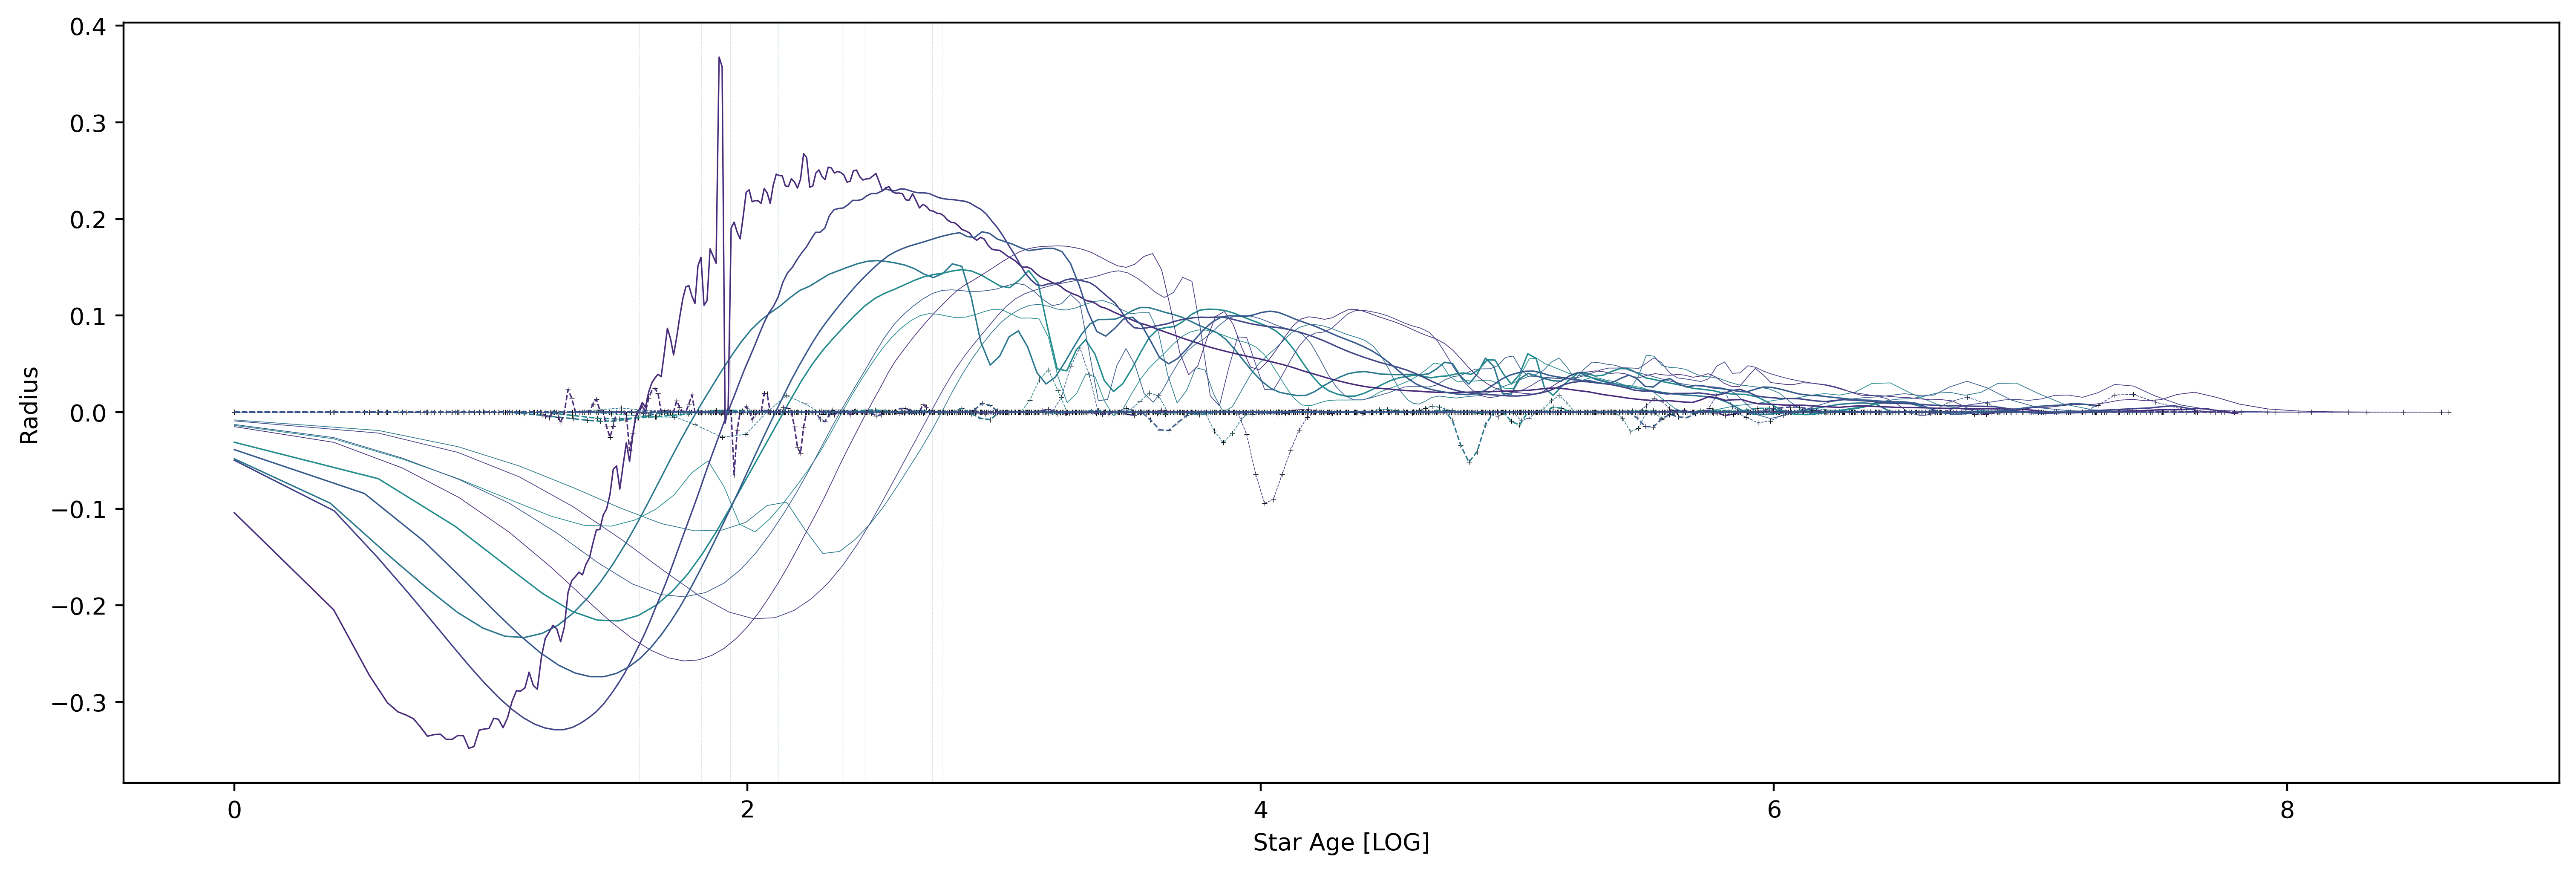

In [60]:
from scipy.interpolate import UnivariateSpline, interp1d
import numpy.ma as ma
from astropy.stats import sigma_clip

# planets = get_data_from_hist(["radius", "log_star_age"])
planets = reduce_to_ass_hist(["radius", "log_star_age"])

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def clip_local_gradients(y, x, window=11, sigma=3, niters=1):
    if window %2 == 0:
        raise ValueError("Window must be odd.")
    _center = int((window - 1) / 2)
    _weights = np.ones(window)
    _weights[_center-2:_center+2] = 1e-8

    _y = np.copy(y)
    new = np.copy(_y)

    n = 0
    solved = 1
    t=False

    while solved > 0 and n < niters:
        n+=1
        mask = np.full_like(y, fill_value=False, dtype=bool)

        for i, (view_y, view_x) in tqdm(enumerate(zip(np.lib.stride_tricks.sliding_window_view(_y, window),
                                                 np.lib.stride_tricks.sliding_window_view(x, window)),
                                             start=_center)):


            clip_mask = sigma_clip(view_y, sigma=sigma, cenfunc="median", masked=True, axis=0, maxiters=1).mask

            corr = UnivariateSpline(view_x[~clip_mask], view_y[~clip_mask], w=_weights[~clip_mask], k=1, s=0)

            clip = sigma_clip(view_y - corr(view_x), sigma=sigma, grow=2, cenfunc="median", masked=False, axis=0, maxiters=1)


            # if np.sum(np.isnan(clip[_center])) > 0:
            #     print(clip[_center])
            #     print(clip)
            #     print(i)
            #     t =True
            #     pass

            mask[i] = np.isnan(clip[_center])

        vx, vy = ma.masked_where(mask, x).compressed(), ma.masked_where(mask, y).compressed()

        new[mask] = interp1d(vx, vy, kind="quadratic")(x[mask])
        solved = np.sum(mask)

        # if t:
        #     print(_y[mask], new[mask])

        t=False

        _y = new

    return _y

# x = np.linspace(0, 6, 200)
# y = np.sin(x)
#
# plt.plot(x, y, ls="dashed")
#
# y[50] += 0.2
# y[52] -= 0.2
#
# y[100] += 2.8
# y[102] -= 0.10
#
# y[140] += 0.3
# y[136] -= 0.1
#
# clip_local_gradients(y, x)
# plt.legend()
# plt.show()
#
#
# raise NotImplementedError

def generate_rad_time_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    # if 10 < m_core < 5:
    #     return
    radius = planet[2]["radius"].to_numpy() # [:-10]
    # radius = (radius - np.min(radius)) / np.max(radius - np.min(radius))
    radius = radius / np.max(radius)
    # radius = radius / np.min(radius)
    log_star_age = planet[2]["log_star_age"].to_numpy() # np.power(10, planet[2]["log_star_age"].to_numpy()) # [:-10]
    log_star_age = (log_star_age - np.min(log_star_age)) # / np.max(log_star_age - np.min(log_star_age))
    # log_star_age = log_star_age / np.max(log_star_age)

    try:
        drdt = np.gradient(radius, log_star_age)
        # drdt_clip = clip_local_gradients(drdt, log_star_age)

        reject_1st = np.sum(np.isnan(drdt))
        if reject_1st != 0:
            print(reject_1st)

        inversion_idx = np.argmin(drdt)

        # log_star_age = log_star_age / log_star_age[inversion]

        ax0.axvline(log_star_age[inversion_idx], c=color_m_core(m_core), ls="dashed", lw=0.2, alpha=0.2)

        ddrddt = np.gradient(drdt, log_star_age)
        ddrddt_clip = clip_local_gradients(ddrddt, log_star_age)

        reject_2nd = np.sum(np.isnan(ddrddt))
        if reject_2nd != 0:
            print(reject_2nd)


        ax0.plot(log_star_age, ddrddt, linewidth=lw_f(f), c=color_m_core(m_core) ) # ls="dashed") # c=color_f(f)) #

        ax0.plot(log_star_age, (ddrddt - ddrddt_clip), linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed") # ls="dashed") # c=color_f(f)) #
        ax0.scatter(log_star_age, (ddrddt - ddrddt_clip), linewidths=0.2, c="black", marker="+", s=4) # ls="dashed") # c=color_f(f)) #

        # # ax0.plot(log_star_age, drdt, linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed")
        # ax0.plot(log_star_age, ddrddt, linewidth=lw_f(f), c=color_m_core(m_core), ) # ls="dashed") # c=color_f(f)) #
        # ax0.scatter(log_star_age, ddrddt, linewidths=0.2, c="black", marker="+", s=4) # ls="dashed") # c=color_f(f)) #
        #
        # # ax0.plot(log_star_age, drdt_clip, linewidth=lw_f(f), c=color_m_core(m_core), ls="-.")
        # ax0.plot(log_star_age, ddrddt_clip, linewidth=lw_f(f), c=color_m_core(m_core), ls="dotted") # ls="dashed") # c=color_f(f)) #

        # ax0.plot(log_star_age, radius, linewidth=lw_f(f), c=color_m_core(m_core), ls="dashed") # c=color_f(f)) #
        # ax0.scatter(log_star_age, radius, c="black", marker="+",linewidths=0.2) # c=color_f(f)) #
        # ax0.plot(x_range, spl(x_range), linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #

        # ax0.plot(x_range, spl.derivative(n=2)(x_range), linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #
    except ValueError:
        pass
        # unique_age, idx = np.unique(log_star_age, return_index=True)
        # print(m_core, f)
        #
        # # idx = np.argwhere(log_star_age[:, 1:] >= log_star_age[:, :-1], axis=1)
        #
        # spl = UnivariateSpline(log_star_age[idx], radius[idx], s=0, k=4)
        #
        # x_range = np.linspace(log_star_age[idx][0],log_star_age[idx][-1], 200)
        # ax0.plot(x_range, spl.derivative(n=2)(x_range), linewidth=lw_f(f), c=color_m_core(m_core)) # c=color_f(f)) #

    return

[generate_rad_time_plt_trace(planet) for planet in planets]# [planets[5]]]

ax0.set_xlabel("Star Age [LOG]")
ax0.set_ylabel("Radius")
# ax0.set_ylim(-1, 1.)
# ax0.set_xscale("log")
# ax0.set_yscale("log")

plt.savefig("radius_star_age.png", dpi=350)
plt.show()

## Interactive plotting

In [90]:
%matplotlib notebook

planets = get_data_from_hist(["radius", "log_star_age"])
planets = densify_planets(planets)

m_core_space = np.linspace(1.0, 25, 10)
f_space = np.logspace(-3, -1, 10)
age_space = np.linspace(0., 6.5, 50)

MM_core_space, FF_space, AAge_space = np.meshgrid(m_core_space, f_space, age_space)
xi = np.array([MM_core_space.flatten(), FF_space.flatten(), AAge_space.flatten()]).T
# print(xi.shape)
# print(FF_space.shape, FF_space)

radii = interp_planet_hist(xi=xi, _planets=planets).reshape(MM_core_space.shape)
# print(radii.shape)

def f_radius(age, m_core, f):
    MM_core_space, FF_space, AAge_space = np.meshgrid([m_core], [f], age)
    xi = np.array([MM_core_space.flatten(), FF_space.flatten(), AAge_space.flatten()]).T
    return interp_planet_hist(xi=xi, _planets=planets).reshape(MM_core_space.shape).flatten()

age_space = np.linspace(0., 6.5, 50)

# Define initial parameters
init_m_core = 5
init_f = 0.1

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(age_space, f_radius(age_space, init_m_core, init_f), lw=lw_m_core(init_m_core), c=color_f(init_f))
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='M_core []',
    valmin=1.5,
    valmax=25,
    valinit=init_m_core,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="f [-]",
    valmin=0.01,
    valmax=0.1,
    valinit=init_f,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f_radius(age_space, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)


# plt.show()

# html_str = mpld3.fig_to_html(fig)
# Html_file= open("interactive_age_radius.html","w")
# Html_file.write(html_str)
# Html_file.close()

mpld3.save_html(fig, "interactive_age_radius.html")

plt.close(fig)
# # Create figure
# fig = go.Figure()
#
# # Add traces, one for each slider step
# for i, m in enumerate(m_core_space):
#     for j, f in enumerate(f_space):
#         fig.add_trace(
#             go.Scatter(
#                 visible=False,
#                 line=dict(color=color_f(f), width=lw_m_core(m)),
#                 name=f"M={m}  f={f}",
#                 x=age_space,
#                 y=radii[i, j]
#             ))
#
# # Make 10th trace visible
# fig.data[0].visible = True
#
# # Create and add slider
# steps = []
# for i in range(len(fig.data)):
#     step = dict(
#         method="update",
#         args=[{"visible": [False] * len(fig.data)},
#               {"title": "Slider switched to step: " + str(i)}],  # layout attribute
#     )
#     step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
#     steps.append(step)
#
# sliders = [dict(
#     active=10,
#     currentvalue={"prefix": "Frequency: "},
#     pad={"t": 50},
#     steps=steps
# )]
#
# fig.update_layout(
#     sliders=sliders
# )
#
# fig.write_html("interactive_age_radius.html")

<IPython.core.display.Javascript object>

C:\Users\lukas\anaconda3\envs\exopa\lib\site-packages\mpld3\mplexporter\exporter.py:84: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



AttributeError: 'Figure' object has no attribute 'close'

### final mass vs radius
The final mass vs. the final radius of the planets.

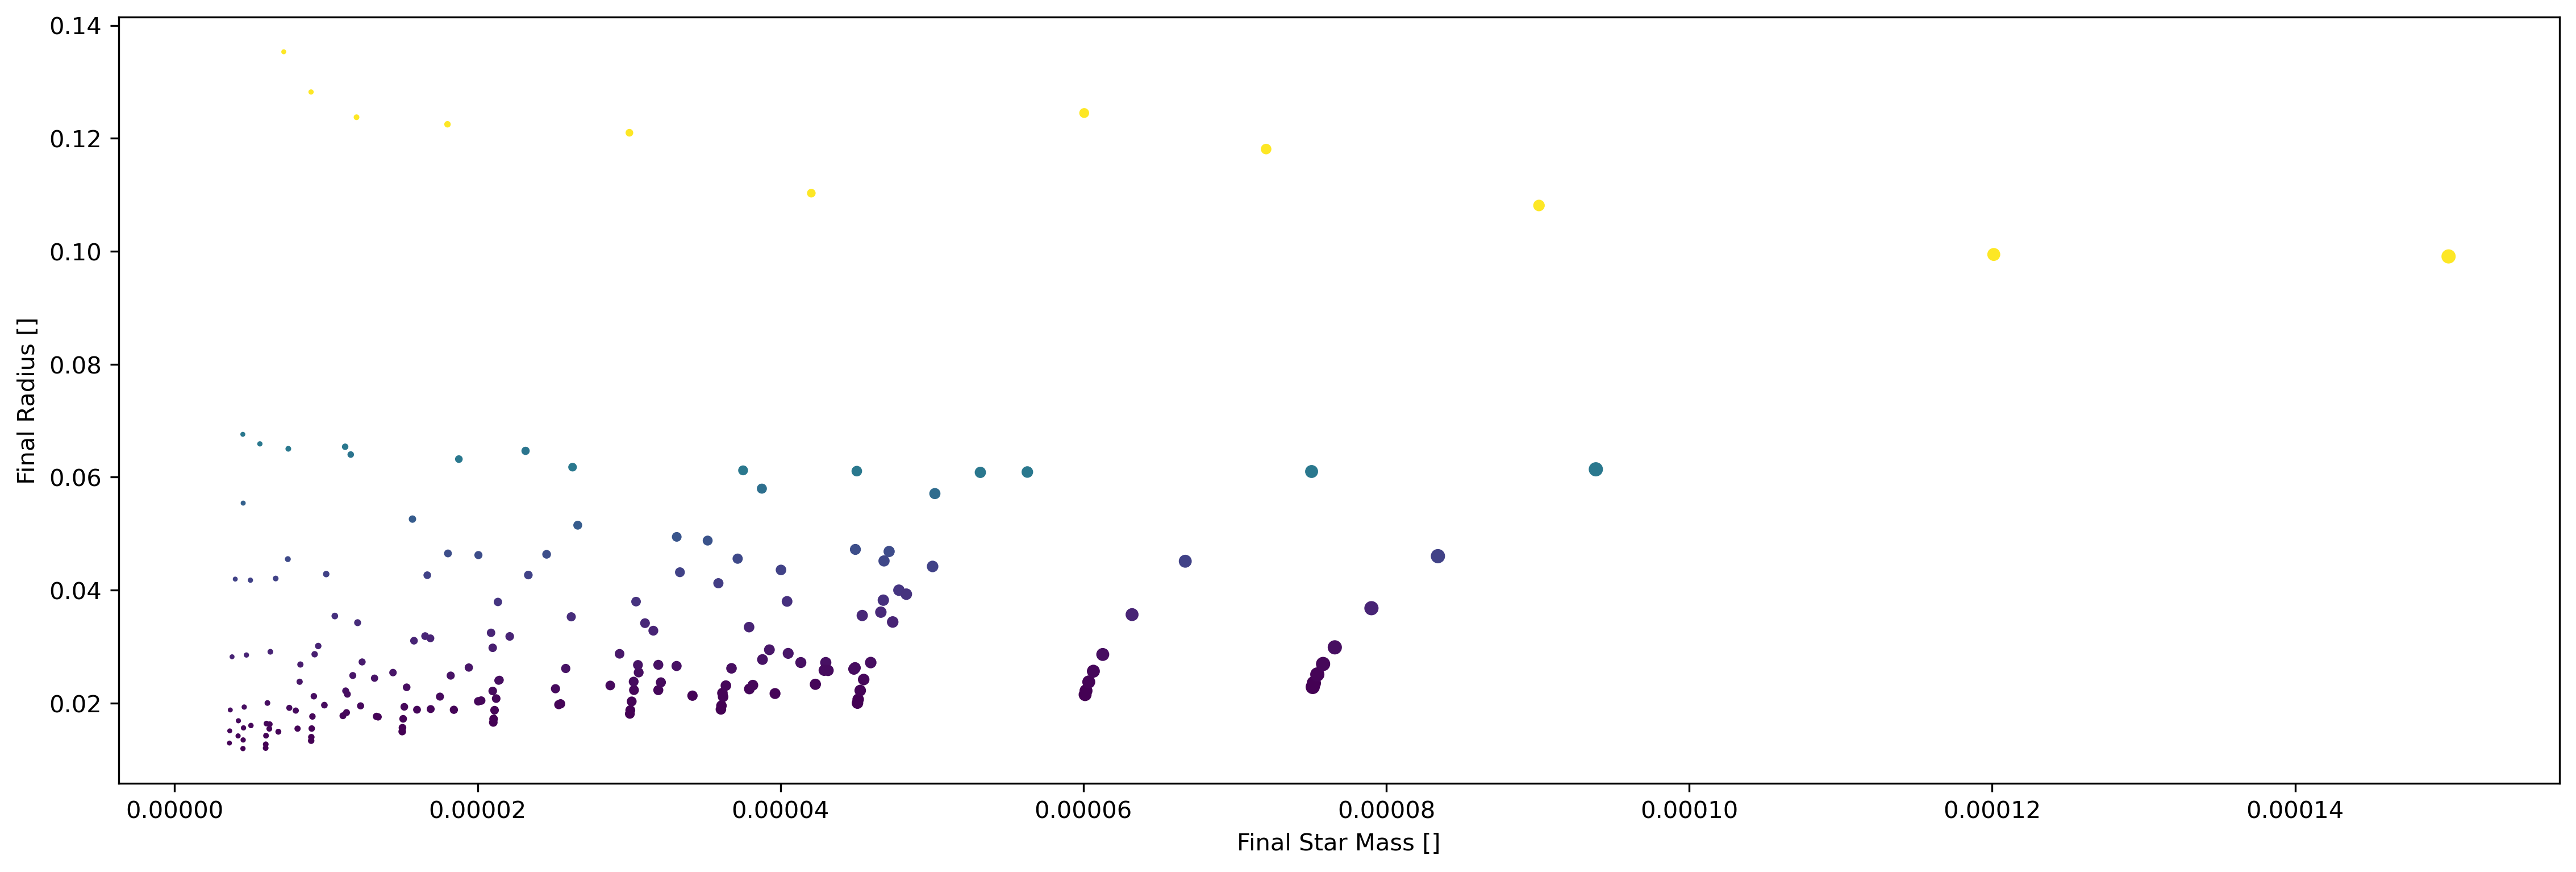

In [46]:
planets = get_data_from_hist(["radius", "star_mass"])

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def format_mass_rad(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["radius"].to_numpy()
    star_mass = planet[2]["star_mass"].to_numpy()
    return [star_mass[-1], radius[-1], m_core, f]

trace = np.array([format_mass_rad(planet) for planet in planets]).T
ax0.scatter(trace[0], trace[1], s=trace[2], c=trace[3])

ax0.set_xlabel("Final Star Mass []")
ax0.set_ylabel("Final Radius []")

plt.savefig("final_mass_radius.png", dpi=350)
plt.show()

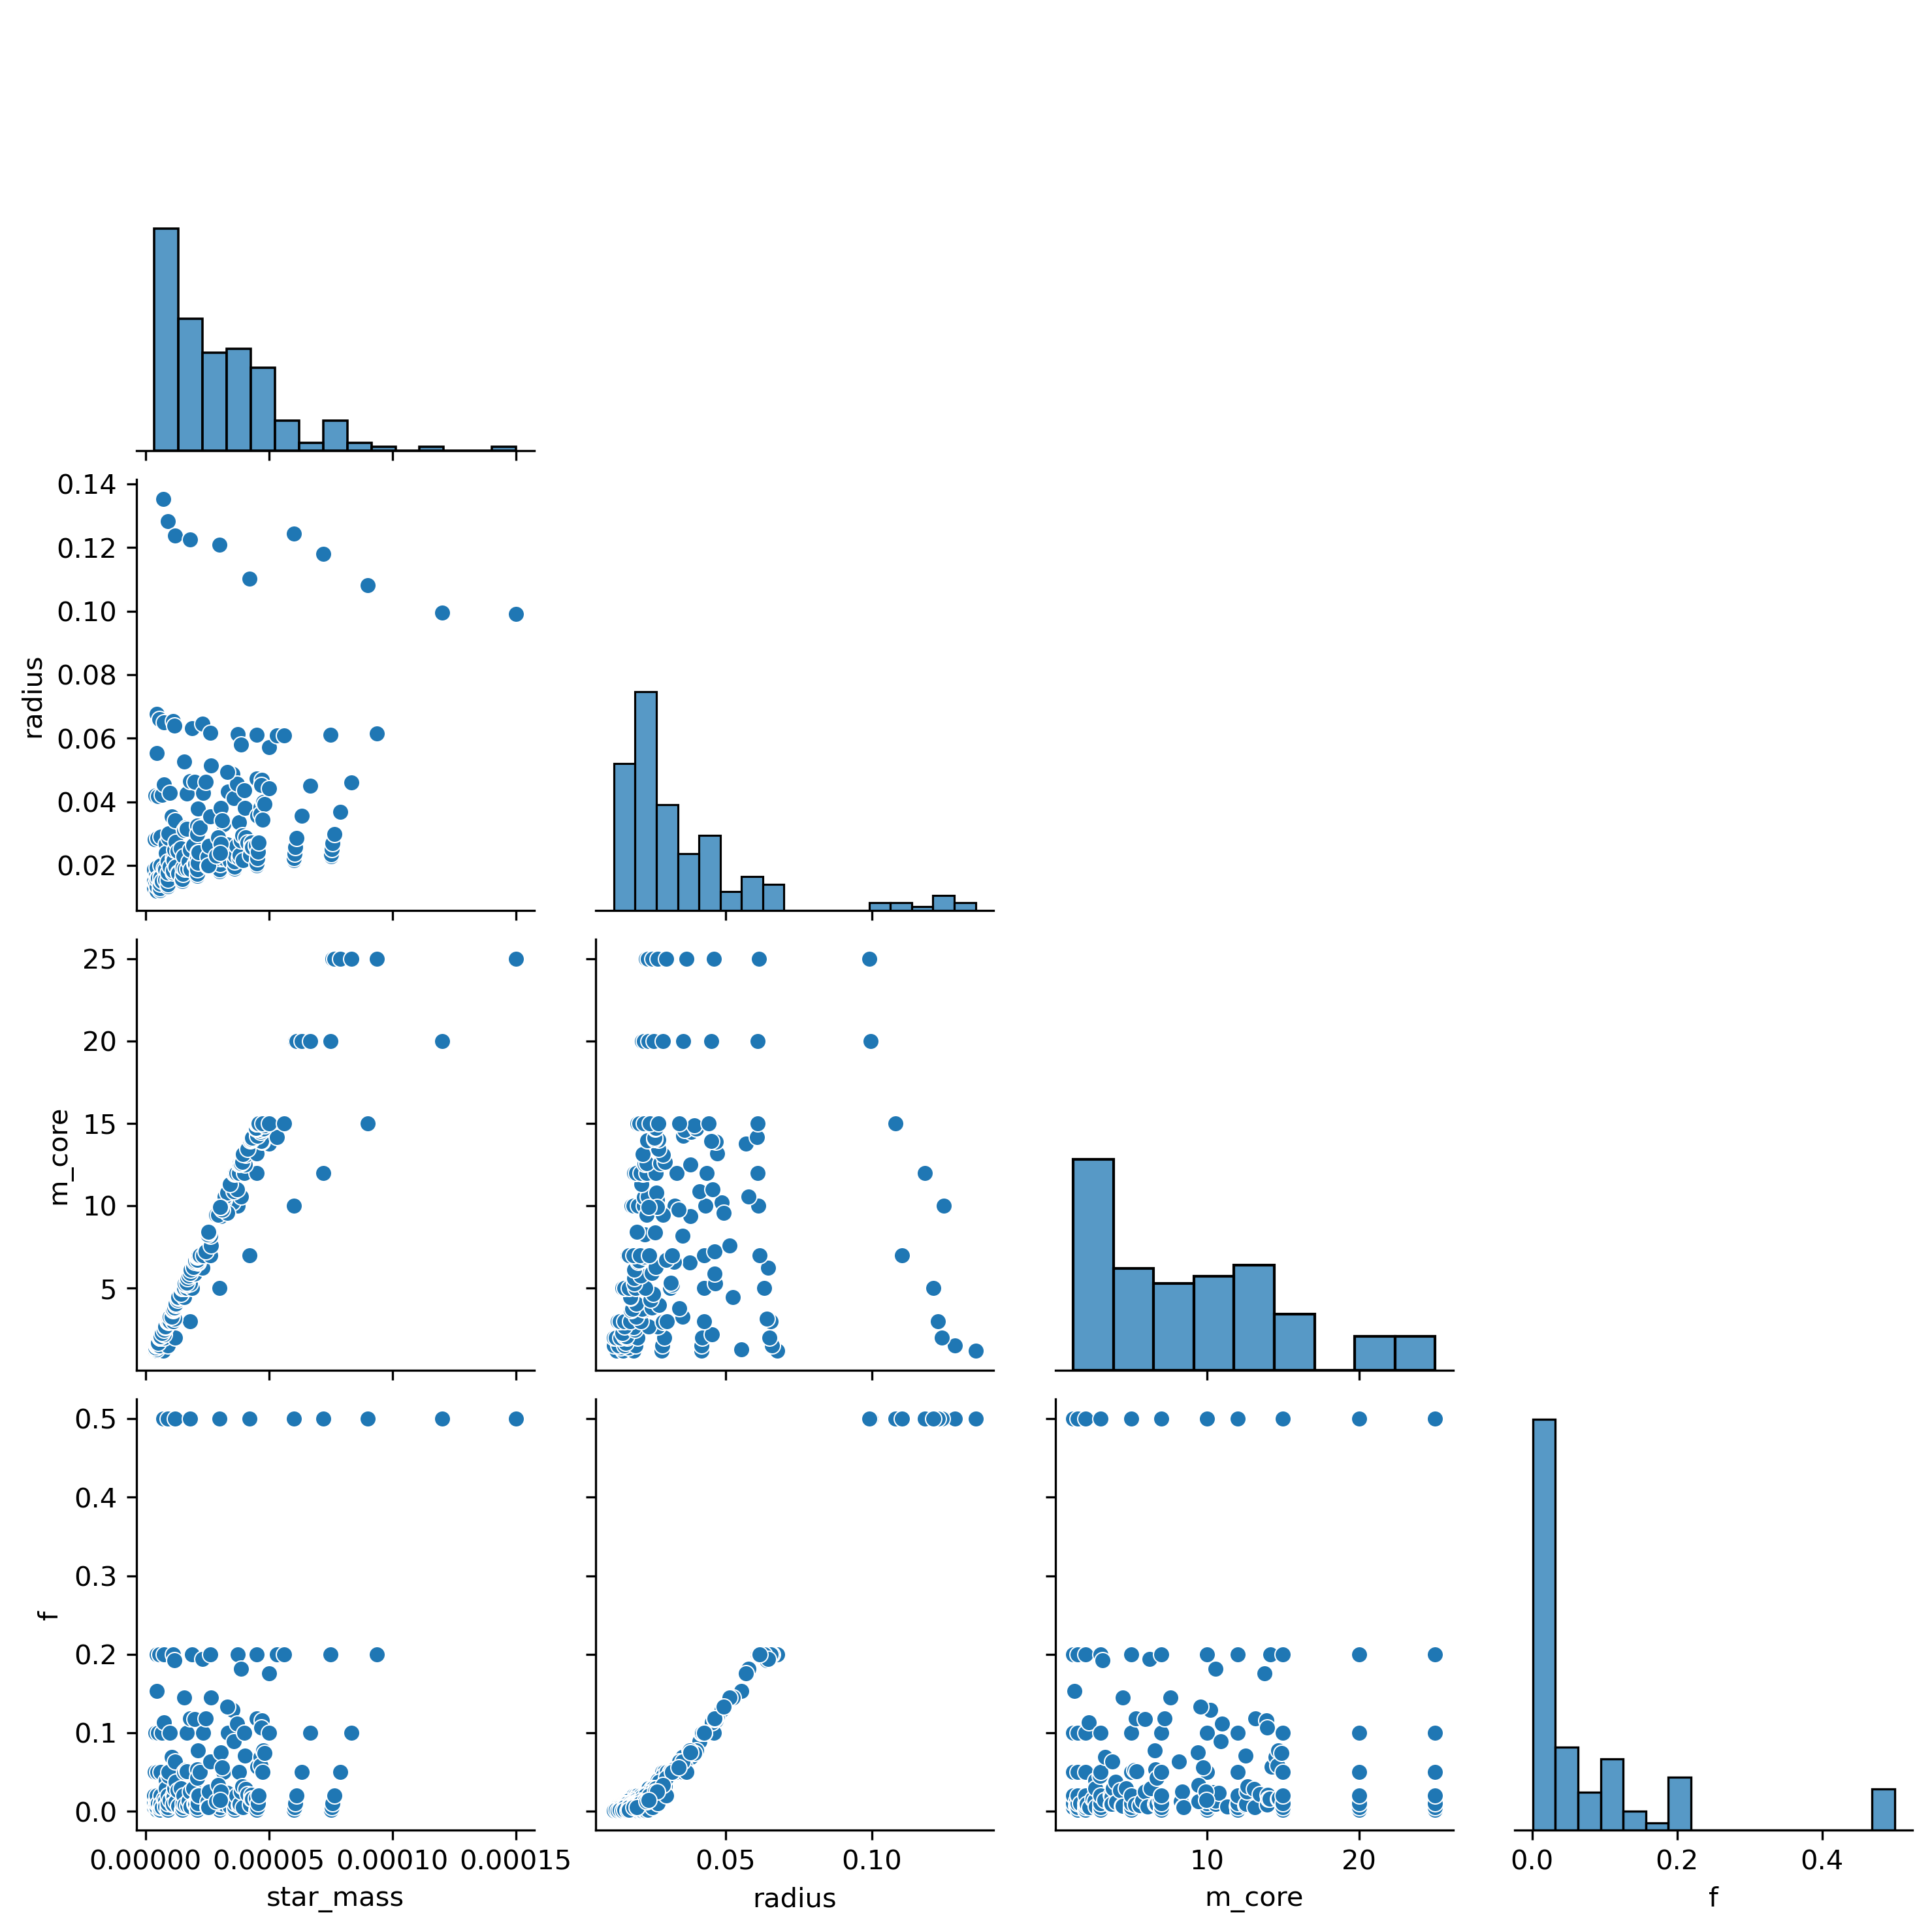

In [47]:
planets = get_data_from_hist(["radius", "star_mass"])
trace = np.array([format_mass_rad(planet) for planet in planets]).T

df = pd.DataFrame(data=trace.T, columns=["star_mass", "radius", "m_core", "f"])

sns.pairplot(df, kind="scatter", diag_kind="hist", corner=True)
plt.show()

### final radiative and adiabatic gradient vs radius
The final radiative and adiabatic gradient (both in the same plot) vs. the radius for each planet.

In [48]:
# from zone_properties: 'grada', 'gradT', 'gradr',
# from history: radius
planets = get_data_from_zone(['logR', 'grada', 'gradr'])
planets = get_final_values_from_zones(planets)

def generate_rad_grads_go_trace(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["logR"].to_numpy()
    grada = planet[2]["grada"].to_numpy()
    gradr = planet[2]["gradr"].to_numpy()

    grada_trace = go.Scatter3d(x=radius,
                         y=grada,
                         z=np.ones_like(radius) * m_core,
                         mode='markers', marker={"size":1,
                                                 "color":np.tile(color_f(f), (len(radius), 1)),
                                                 # "colorscale": 'Viridis',
                                                 "opacity":0.8
                                                 }
                         )

    gradr_trace = go.Scatter3d(x=radius,
                     y=gradr,
                     z=np.ones_like(radius) * m_core,
                     mode='markers', marker={"size":1,
                                                 "color":np.tile(color_f(f), (len(radius), 1)),
                                                 # "colorscale": 'Viridis',
                                                 "opacity":0.8
                                                 }
                     )

    return [grada_trace, gradr_trace]

traces = list(np.array([generate_rad_grads_go_trace(planet) for planet in planets]).flatten())

# print(traces.shape)

fig = go.Figure(data=traces,)

fig.update_layout(
    scene = dict(
        xaxis_title='Planet Radius [log]',
        yaxis_title='Gradient[-]',
        zaxis_title='m_core []',
    # zaxis=dict(type='log')
    ),
)

# ply.iplot(fig, filename='radius_gradients')
fig.write_html("radius_gradients.html")

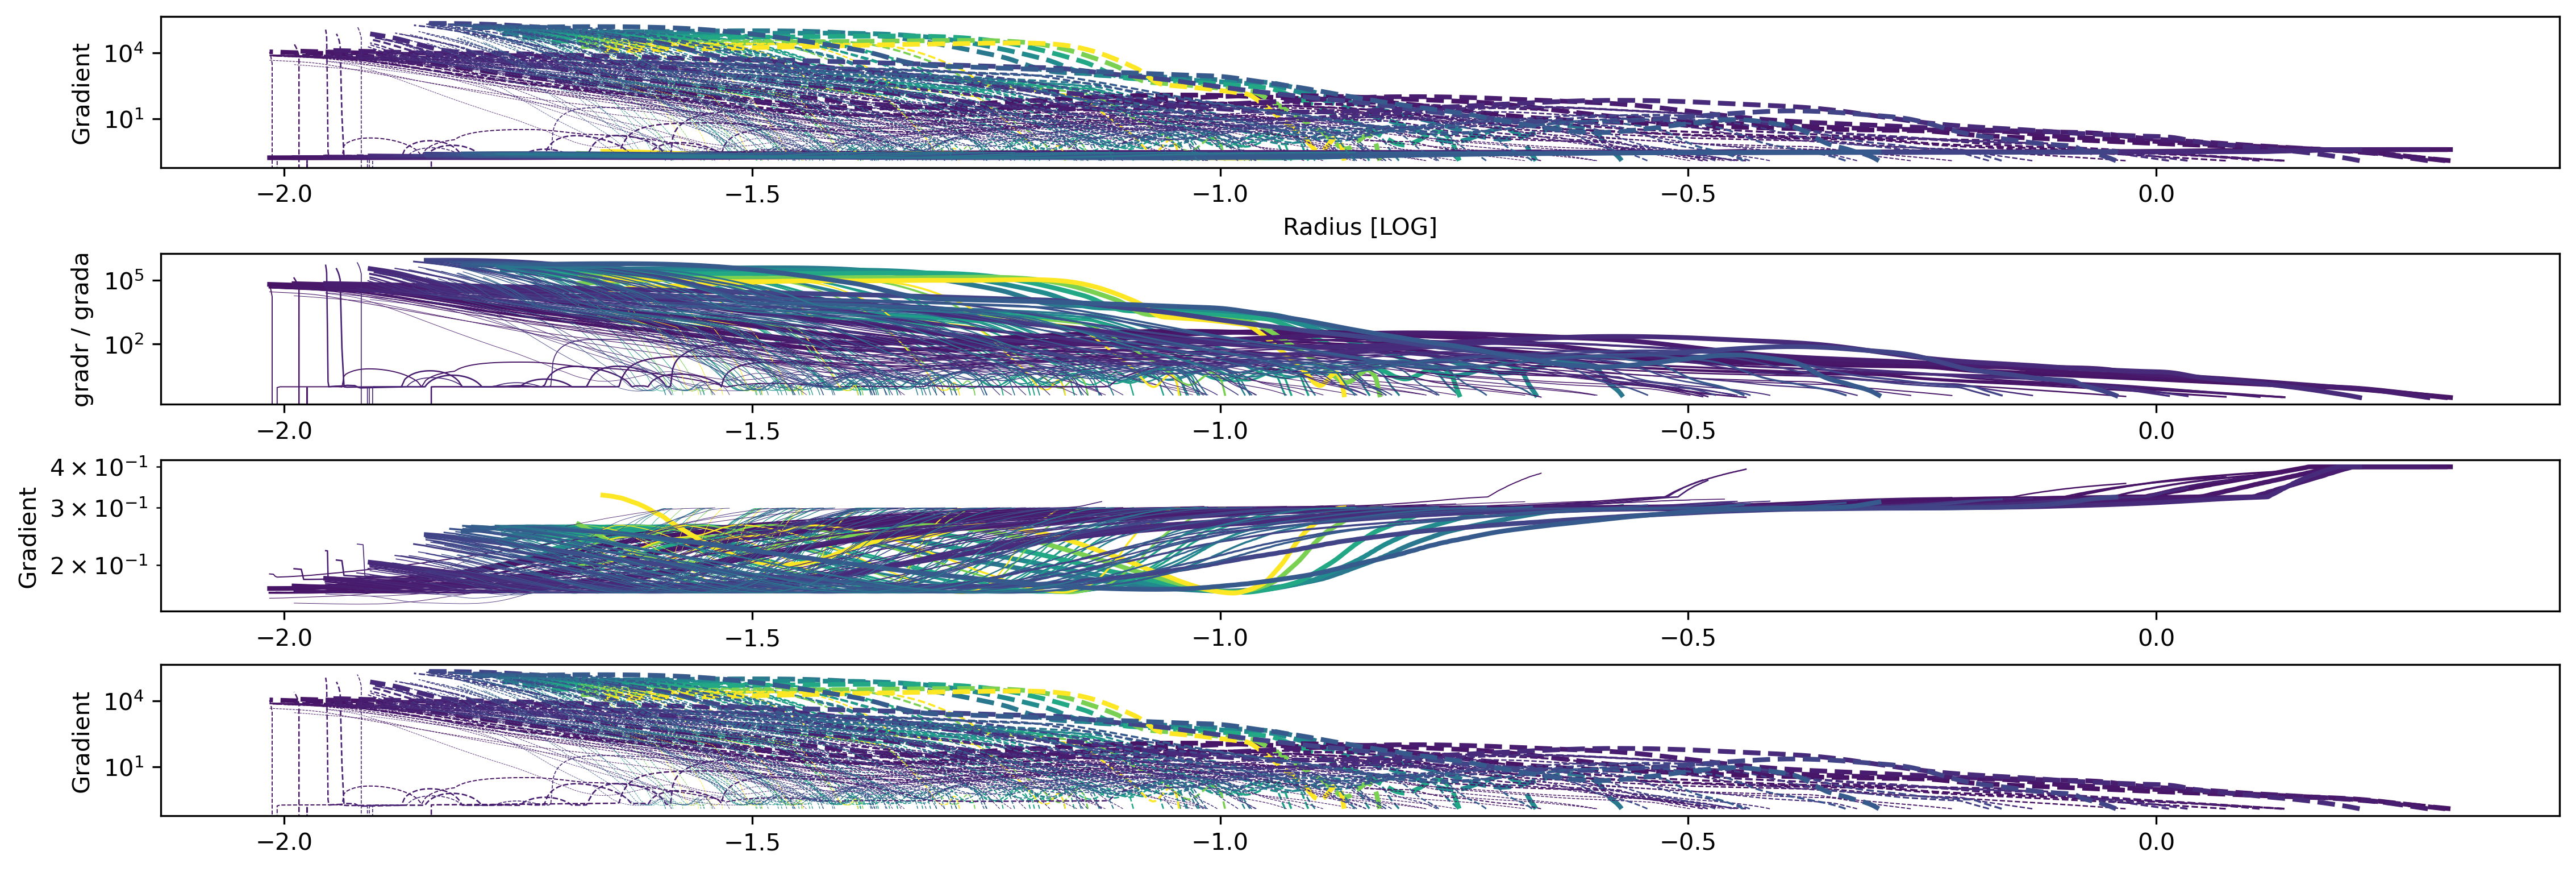

In [49]:
# from zone_properties: 'grada', 'gradT', 'gradr',
# from history: radius
planets = get_data_from_zone(['logR', 'grada', 'gradr'])
planets = get_final_values_from_zones(planets)

fig, (ax0, ax3, ax1, ax2) = plt.subplots(nrows=4, constrained_layout=True,)# figsize=(5,5))

def generate_rad_grads_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["logR"].to_numpy()
    grada = planet[2]["grada"].to_numpy()
    gradr = planet[2]["gradr"].to_numpy()

    ax0.plot(radius, grada, ls="solid", linewidth=lw_f(f), c=color_m_core(m_core))
    ax1.plot(radius, grada, ls="solid", linewidth=lw_f(f), c=color_m_core(m_core))

    ax0.plot(radius, gradr, ls="dashed", linewidth=lw_f(f), c=color_m_core(m_core))
    ax2.plot(radius, gradr, ls="dashed", linewidth=lw_f(f), c=color_m_core(m_core))

    ax3.plot(radius, gradr / grada, ls="solid", linewidth=lw_f(f), c=color_m_core(m_core))
    return

[generate_rad_grads_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Radius [LOG]")
ax0.set_ylabel("Gradient")
ax0.set_yscale("log")

ax3.set_ylabel("gradr / grada")
ax3.set_yscale("log")

ax1.set_ylabel("Gradient")
ax1.set_yscale("log")

ax2.set_ylabel("Gradient")
ax2.set_yscale("log")

plt.savefig("radius_gradients.png", dpi=350)
plt.show()

### final temperature vs pressure
The final temperature-pressure profile for each planet atmosphere.

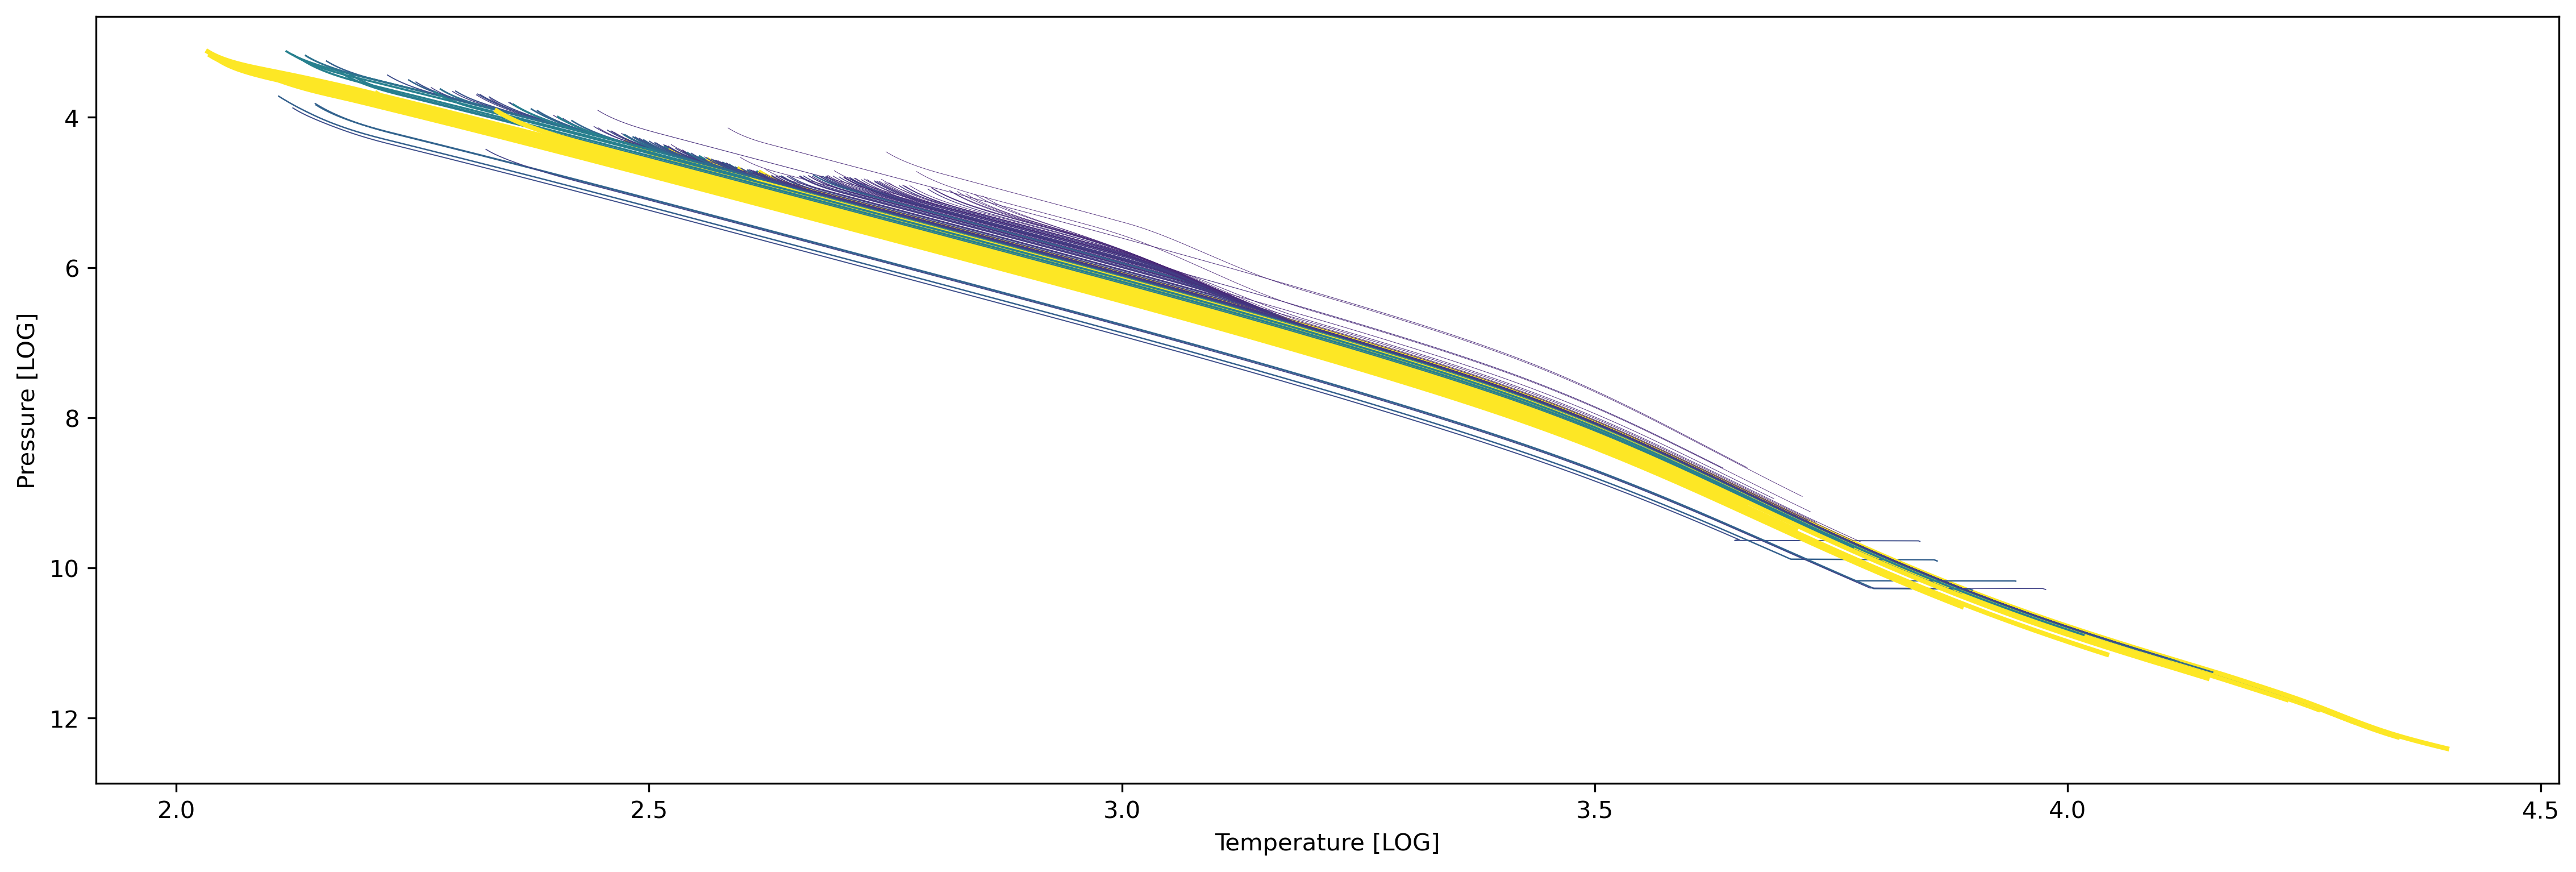

In [50]:
# from zone_properties: 'logT', 'logP'
planets = get_data_from_zone(['logT', 'logP'])
planets = get_final_values_from_zones(planets)

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_temp_pressure_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    logT = planet[2]["logT"].to_numpy()
    logP = planet[2]["logP"].to_numpy()

    ax0.plot(logT, logP, ls="solid", c=color_f(f), linewidth=lw_f(f))
    return

[generate_temp_pressure_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Temperature [LOG]")
ax0.set_ylabel("Pressure [LOG]")
ax0.invert_yaxis()

plt.savefig("temp_pressure.png", dpi=350)
plt.show()

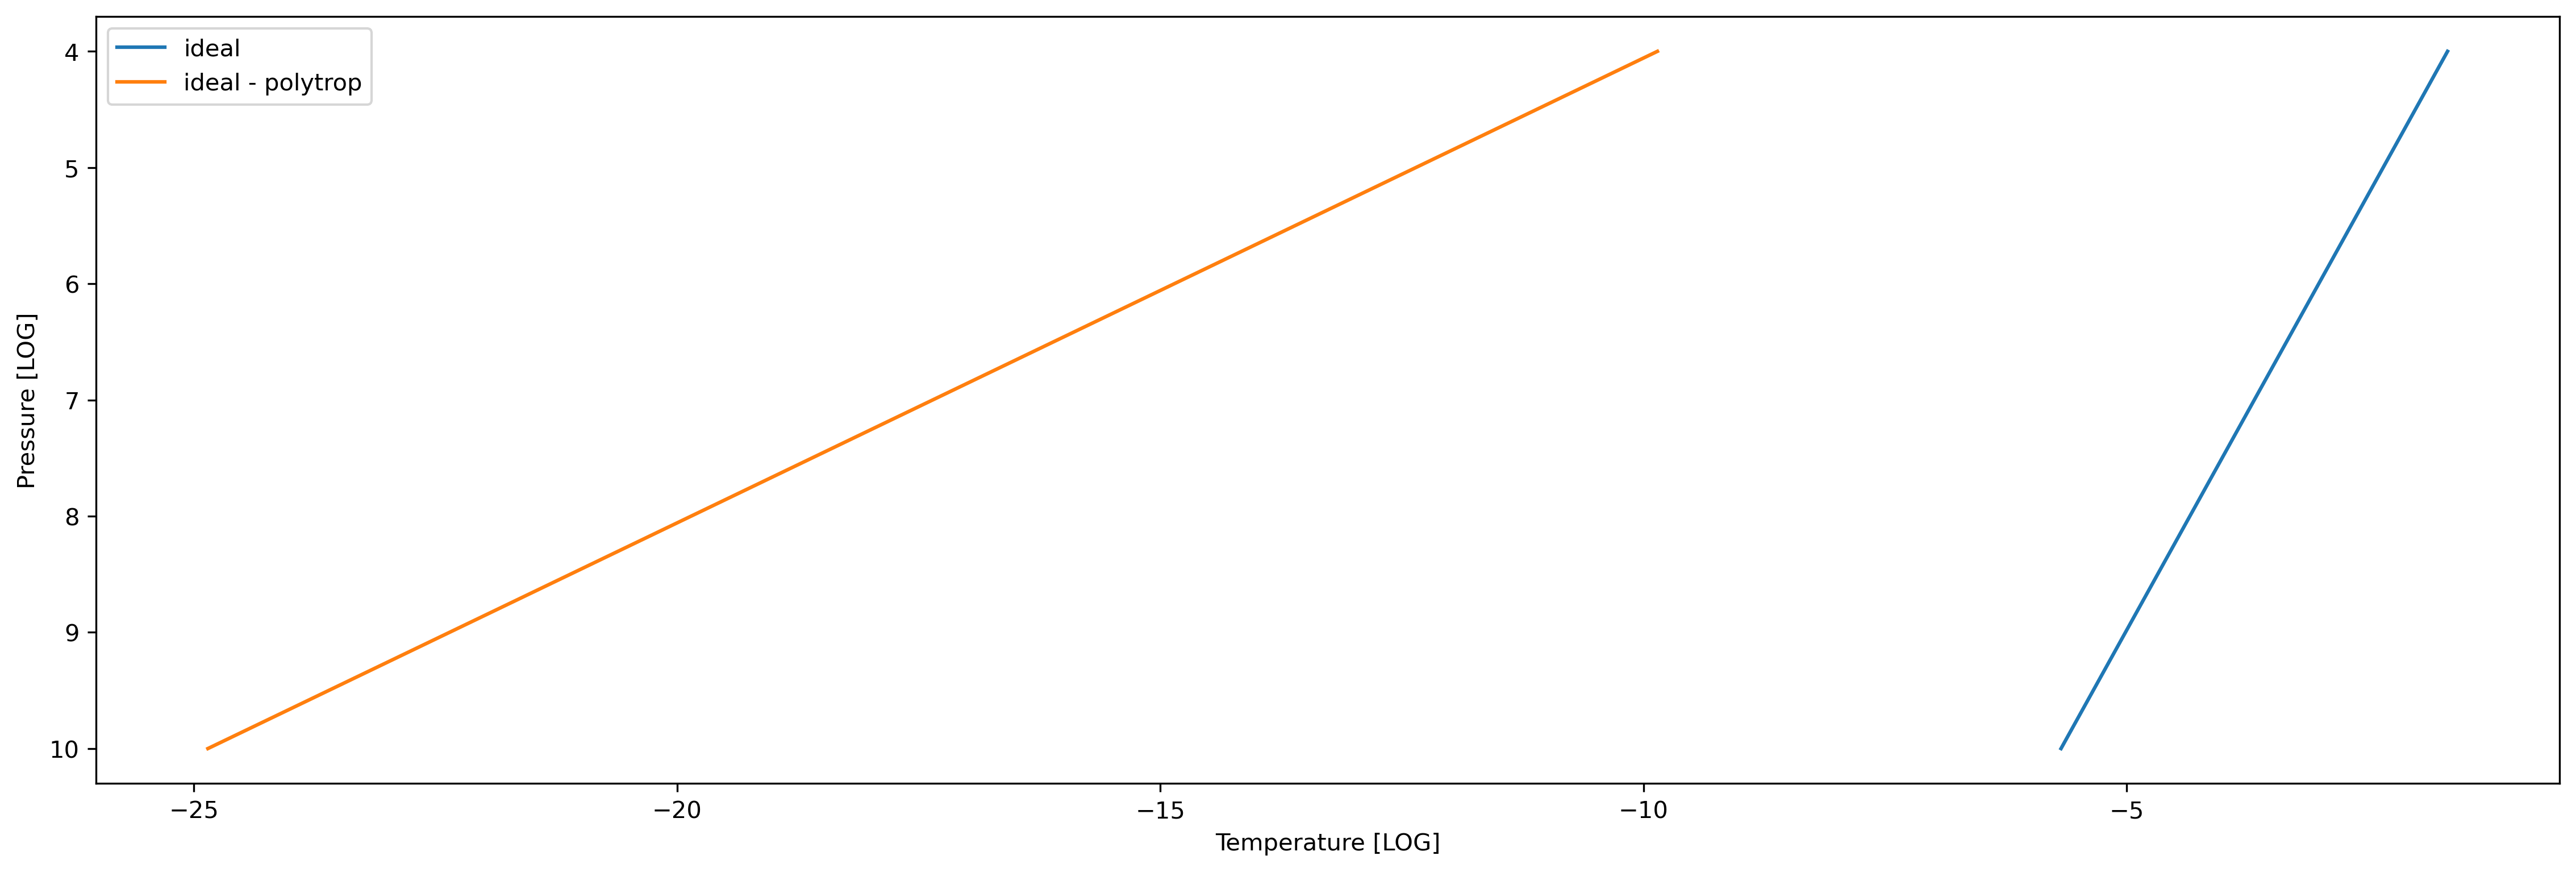

In [51]:
mu = 2.56
G = 6.674e-11
#  below: http://u.arizona.edu/~dpsaltis/Phys305/spring2011.pdf
c = 0.00311  # H2O
rho_0 = 1460.00 # H2O
K = 0.513  # H2O

def rho_mod_polytrop_EOS(P, rho_0=1460.00, K=0.513, n=1.5):
    """
    Modified polytropic equation of state
    """
    return rho_0 + K * P ** ( (n+ 1) / n)

def temp_ideal_EOS(rho, P, K=0.513, H=1, mu=2.56):
    """
    Ideal gas assumption
    """
    return P / (rho * K) * mu * H

def temp_mod_polytrop_EOS(rho, P, K=0.513, n=1.5):
    """
    Ideal gas assumption
    """
    return K / (rho ** n)

def mass_radius_polytrop(m, K=0.513, G=6.674e-11):
    """
    Mass radius relationship for a n=1.5 polytrop
    """
    return m ** 3 * K / (0.4242 * G)

planets = get_data_from_zone(["mu"])

P_list = np.logspace(4, 10, 100)
rho = rho_mod_polytrop_EOS(P_list)
temp_ideal = temp_ideal_EOS(rho, P_list)
temp_poly = temp_mod_polytrop_EOS(rho, P_list)

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_theory_temp_pressure_plt_trace(_P, _T, label):
    ax0.plot(np.log10(_T), np.log10(_P), ls="solid", label=label)
    return

[generate_theory_temp_pressure_plt_trace(P, T, label) for ((P, T), label) in zip([
    [P_list, temp_ideal],
    [P_list, temp_poly]
], ["ideal", "ideal - polytrop"]
)]

ax0.set_xlabel("Temperature [LOG]")
ax0.set_ylabel("Pressure [LOG]")
ax0.invert_yaxis()
ax0.legend()

# plt.savefig("theory_temp_pressure.png", dpi=350)
plt.show()

### mass vs age

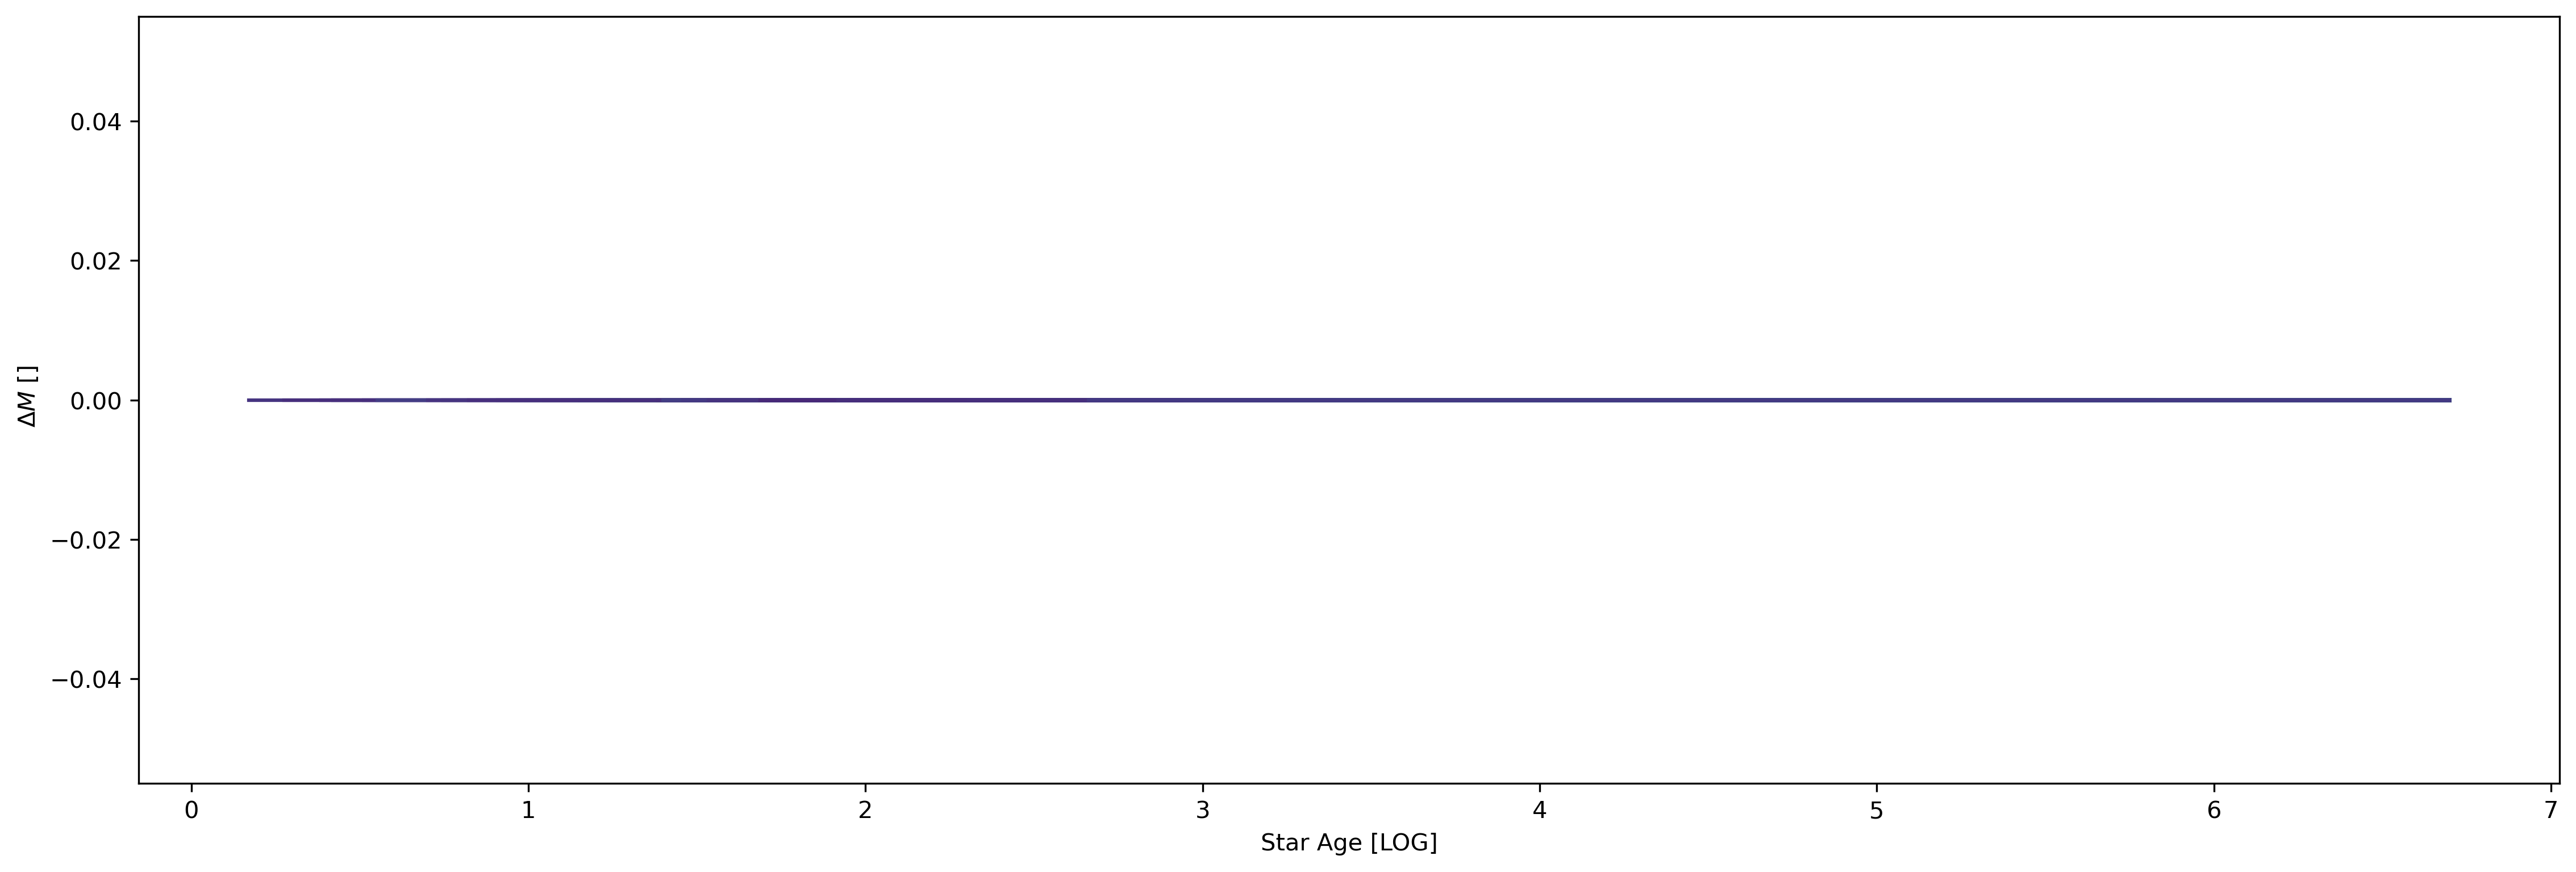

In [52]:
planets = get_data_from_hist(["star_mass", "log_star_age"])

fig, ax0 = plt.subplots(constrained_layout=True,)# figsize=(5,5))

def generate_mass_time_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    star_mass = planet[2]["star_mass"].to_numpy()
    star_mass = star_mass / np.max(star_mass)
    d_star_mass = [star_mass[i+1] - star_mass[i] for i in range(len(star_mass) - 1)]
    log_star_age = planet[2]["log_star_age"].to_numpy()[1:]
    # log_star_age = (log_star_age - np.min(log_star_age))/ np.max(log_star_age - np.min(log_star_age))
    ax0.plot(log_star_age, d_star_mass, c=color_f(f))
    return

[generate_mass_time_plt_trace(planet) for planet in planets]

ax0.set_xlabel("Star Age [LOG]")
ax0.set_ylabel(r" $\Delta M$ []")

plt.savefig("mass_star_age.png", dpi=350)
plt.show()

## Interpolation of data

In [67]:
planets = get_data_from_hist(["radius", "log_star_age"])

def densify_planets(_planets):
    """
    Produce a dense DataFrame from a list of [[m_core, f, DataFrame], ...] where each row has the m_core, f as columns fo the DataFrame
    :param _planets:
    :return:
    """
    for i, planet in enumerate(_planets):
        _planets[i][2].insert(0, "m_core", planet[0])
        _planets[i][2].insert(1, "f", planet[1])
        _planets[i] = _planets[i][2]
    return pd.concat(_planets, axis=0)

planets = densify_planets(planets)

cols = ["m_core", "f", "log_star_age"]
points = planets[cols].to_numpy()

def interp_planet_hist(xi, _planets, point_cols=["m_core", "f", "log_star_age"], value_cols=["radius"]):
    return griddata(points=_planets[point_cols].to_numpy(),
                    values=_planets[value_cols].to_numpy(),
                    xi=xi,
                    method="linear", rescale=True)

request = [[11.5, 0.09, 5.4],
           [5.9, 0.07, 6.4]]

print(interp_planet_hist(request, _planets=planets))



[[0.06237781]
 [0.03953402]]


# Questions
1. Units documentation
2. Star age, mass of star or of planet?
3. Configuration? Star flux, no evaporation etc...?
4. Polytropes
5. Configuration, parameterization (wrt m_core, f), model/theory?

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2